In [1]:
#导入相关函数库
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import re
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 80)
from pandas.tseries.offsets import DateOffset


## Step1：数据处理  
导入雪球平台讨论和2010年11月至2023年10月的公司公告的月度情感均值，导入对应日期的股票回报率和无风险利率。  
依照月份与股票代码进行合并，得到2010年11月至2023年10月的情感分歧以及2010年11月至2023年11月股票的超额收益率。
对数据进行描述性统计

In [2]:
post_emo = pd.read_excel(r'E:\雪球发帖情感按月聚合\全部月度雪球情感.xlsx')
display(post_emo)
#post_emo = pd.read_excel(r"E:\月度雪球情感(all).xlsx")

post_emo['Stkcd']=post_emo['Stkcd'].astype(str).str.zfill(6)
display(post_emo)

announce_emo = pd.read_excel(r"E:\公司情感按月聚合总.xlsx")
announce_emo['Stkcd']=announce_emo['Stkcd'].astype(str).str.zfill(6)
display(announce_emo)

stk_r = pd.read_csv(r"E:\股票月回报率.csv")
stk_r['Stkcd']=stk_r['Stkcd'].astype(str).str.zfill(6)
stk_r.rename(columns={'Trdmnt': 'month'}, inplace=True)

Nrrate = pd.read_excel(r"E:\月度平均无风险利率.xlsx")
display(stk_r)
display(Nrrate)

,Stkcd,month,post_emo
0,2,2010-11,0.000000
1,2,2010-12,0.000000
2,2,2011-01,0.000000
3,2,2011-02,0.000000
4,2,2011-03,0.000000
...,...,...,...
778903,873593,2023-06,0.023266
778904,873593,2023-07,0.024569
778905,873593,2023-08,0.019093
778906,873593,2023-09,0.030480


,Stkcd,month,post_emo
0,000002,2010-11,0.000000
1,000002,2010-12,0.000000
2,000002,2011-01,0.000000
3,000002,2011-02,0.000000
4,000002,2011-03,0.000000
...,...,...,...
778903,873593,2023-06,0.023266
778904,873593,2023-07,0.024569
778905,873593,2023-08,0.019093
778906,873593,2023-09,0.030480


,Stkcd,month,announce_emo
0,000002,2011-06,0.014132
1,000006,2010-11,0.004136
2,000006,2010-12,0.001847
3,000006,2011-01,0.007076
4,000006,2011-03,0.017079
...,...,...,...
416749,873593,2023-05,0.011982
416750,873593,2023-06,0.013842
416751,873593,2023-08,0.011700
416752,873593,2023-09,0.018387


,Stkcd,month,Mclsprc,Msmvosd,Mretwd
0,000002,2009-06,12.75,1.197492e+08,0.314909
1,000002,2009-07,13.36,1.254784e+08,0.047843
2,000002,2009-08,9.40,8.828569e+07,-0.296407
3,000002,2009-09,10.42,9.786563e+07,0.108511
4,000002,2009-10,11.51,1.081030e+08,0.104607
...,...,...,...,...,...
505376,873693,2023-10,34.55,4.177786e+05,NaN
505377,873693,2023-11,49.96,6.041163e+05,0.446020
505378,873726,2023-10,21.80,4.533911e+05,NaN
505379,873726,2023-11,29.15,5.084173e+05,0.337156


,month,月度化无风险利率(%)
0,2010-11,0.206000
1,2010-12,0.209929
2,2011-01,0.226300
3,2011-02,0.240800
4,2011-03,0.246600
...,...,...
152,2023-07,0.124100
153,2023-08,0.124100
154,2023-09,0.124100
155,2023-10,0.124100


### 情感指标，超额收益率导入

In [3]:
divergence = pd.merge(post_emo, announce_emo, on = ['Stkcd','month'])
divergence = divergence.drop_duplicates()
divergence['emo_dv'] = divergence['post_emo'] - divergence['announce_emo']

# 归一化
divergence['emo_dv'] = ((divergence['post_emo'] - divergence['post_emo'].mean()) / divergence['post_emo'].std()) - \
                             ((divergence['announce_emo'] - divergence['announce_emo'].mean()) / divergence['announce_emo'].std())

divergence = pd.merge(divergence, stk_r, on = ['Stkcd','month'], how='right') #
divergence = pd.concat([divergence[divergence['month'] != '2023-11'].dropna(),divergence[divergence['month'] == '2023-11']])


divergence = pd.merge(divergence, Nrrate, on = 'month')
divergence = divergence.sort_values(by=['Stkcd','month'])
divergence['excess return'] = divergence['Mretwd'] - divergence['月度化无风险利率(%)']/100
divergence = divergence.reset_index(drop=True)
display(divergence)
display(divergence.describe())
divergence['excess return'] = divergence.groupby(['Stkcd'])['excess return'].shift(-1)

divergence['month'] = pd.to_datetime(divergence['month'], format='%Y-%m')
divergence['year'] = divergence['month'].dt.year
divergence['sft_year'] = (divergence['month'] - DateOffset(months=6)).dt.year


,Stkcd,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return
0,000002,2011-06,-0.000665,0.014132,-0.849500,8.45,8.161499e+07,0.077806,0.2669,0.075137
1,000002,2013-01,0.009261,0.010301,0.372211,12.01,1.160430e+08,0.186759,0.2466,0.184293
2,000002,2014-05,0.006244,0.030562,-2.290318,8.55,8.273138e+07,0.142649,0.2466,0.140183
3,000002,2014-06,0.006960,0.008348,0.429874,8.27,7.998672e+07,-0.032749,0.2466,-0.035215
4,000002,2014-07,0.008438,0.023912,-1.324055,9.90,9.575194e+07,0.197098,0.2466,0.194632
...,...,...,...,...,...,...,...,...,...,...
401279,873665,2023-11,NaN,NaN,NaN,8.92,2.942994e+05,0.567663,0.1241,0.566422
401280,873679,2023-11,NaN,NaN,NaN,23.00,2.938940e+05,NaN,0.1241,NaN
401281,873693,2023-11,NaN,NaN,NaN,49.96,6.041163e+05,0.446020,0.1241,0.444779
401282,873726,2023-11,NaN,NaN,NaN,29.15,5.084173e+05,0.337156,0.1241,0.335915


,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return
count,396247.000000,396247.000000,396247.000000,401284.000000,4.012840e+05,401267.000000,401284.000000,401267.000000
mean,0.011446,0.014724,0.009291,19.676772,9.935748e+06,0.010046,0.154222,0.008503
std,0.012962,0.008390,1.323355,35.158533,3.667393e+07,0.146313,0.054171,0.146297
min,-0.142857,-0.081695,-14.502185,0.120000,5.542006e+04,-0.863517,0.124100,-0.864758
25%,0.000000,0.009393,-0.779751,7.080000,2.045098e+06,-0.071226,0.124100,-0.072724
50%,0.010830,0.014200,0.009375,12.160000,3.930554e+06,-0.003416,0.124100,-0.004931
75%,0.018937,0.019420,0.806695,21.540000,8.310784e+06,0.071429,0.144700,0.069911
max,0.190476,0.140371,14.727782,2218.000000,2.786247e+09,5.116070,0.287100,5.114829


In [4]:
divergence = divergence.groupby('month').apply(lambda x: x[x['Msmvosd'] < x['Msmvosd'].quantile(0.3)]).reset_index(drop=True)

### 财务指标导入

“市值” (Size) 指标是以股票 i在第 t 年 6月底的流通市值；
“账面市值比”(BM)是用第t-1年末的“账面价值/股票i的流通市值”；
“资产收益率”(OP)是用第t-1年末的“资产收益率”；
“资产增长率”(AG)是用第t-1年末相对于第t-2年末的总资产增加额，除以第t-2年末的总资产。

In [5]:
feature_df = pd.read_csv(r"E:\财务指标文件\CSR_Finidx.csv")
feature_df['Stkcd']=feature_df['Stkcd'].astype(str).str.zfill(6)
feature_df['Accper']=pd.to_datetime(feature_df['Accper'])
display(feature_df)

,Stkcd,Accper,A100000,A200000,A300000,B150101,T40401,T40402,T40403,T40801,T40802,T40803,T60200,T40902,Outcap
0,000002,2008-12-31,1.192366e+11,8.041803e+10,3.189193e+10,4.639869e+09,0.038913,0.042309,0.042309,0.126464,0.131866,0.131866,0.421990,0.151396,2.152837e+08
1,000002,2009-12-31,1.376086e+11,9.220004e+10,3.737589e+10,6.430008e+09,0.046727,0.050069,0.050069,0.142598,0.153888,0.153888,0.584801,0.193966,8.060622e+08
2,000002,2010-12-31,2.156376e+11,1.610514e+11,4.423268e+10,8.839611e+09,0.040993,0.050048,0.050048,0.164655,0.178489,0.178489,0.803951,0.037342,2.619386e+08
3,000002,2011-12-31,2.962084e+11,2.283759e+11,5.296780e+10,1.159961e+10,0.039160,0.045325,0.045325,0.181712,0.198042,0.198042,1.054969,0.411367,2.615609e+08
4,000002,2012-12-31,3.788016e+11,2.966634e+11,6.382555e+10,1.566259e+10,0.041348,0.046407,0.046407,0.196648,0.214930,0.214930,1.424448,0.438351,1.506676e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49049,873806,2021-12-31,5.124748e+09,4.135552e+09,9.066493e+08,1.221275e+08,0.023831,0.022725,NaN,0.121368,0.129208,NaN,NaN,NaN,2.139889e+07
49050,873806,2022-12-31,3.780017e+09,2.829279e+09,9.462263e+08,1.023510e+08,0.027077,0.022988,0.022988,0.104192,0.106417,0.106417,NaN,NaN,4.870094e+07
49051,873806,2023-12-31,3.210519e+09,2.144021e+09,1.061128e+09,1.157604e+08,0.036057,0.033119,0.033119,0.108283,0.114481,0.114481,NaN,NaN,5.940754e+07
49052,873833,2022-12-31,7.068130e+08,2.272433e+08,4.777225e+08,5.065831e+07,0.071671,0.071819,NaN,0.107403,0.110842,NaN,NaN,NaN,3.961650e+07


#### 市值计算

In [6]:
# 创建一个新的 DataFrame 存储指定条件下的信息
indicators = pd.DataFrame()
stk_r['month'] = pd.to_datetime(stk_r['month']).dt.to_period("M")
# 提取 'Trdmnt' 列的年份和月份
stk_r['Year'] = stk_r['month'].dt.year
stk_r['mon_id'] = stk_r['month'].dt.month

# 筛选条件：股票 i 在第 t 年 6 月底
condition = (stk_r['mon_id'] == 6)

# 将符合条件的数据存储到新的 DataFrame 中
indicators['Stkcd'] = stk_r.loc[condition, 'Stkcd']
indicators['Period'] = stk_r.loc[condition, 'Year']
indicators['Size'] = stk_r.loc[condition, 'Msmvosd']*1000

# 打印新的 DataFrame
display(indicators)

,Stkcd,Period,Size
0,000002,2009,1.197492e+11
12,000002,2010,6.546822e+10
24,000002,2011,8.161499e+10
36,000002,2012,8.608689e+10
48,000002,2013,9.517262e+10
...,...,...,...
505313,873223,2023,2.388880e+08
505325,873305,2023,1.119294e+08
505338,873339,2023,2.585521e+08
505352,873527,2023,1.728361e+08


#### 账面市值比计算

In [7]:
#获取年末账面价值
BM_book_value = feature_df[['Stkcd','Accper','A300000']]
BM_book_value['Accper'] = pd.to_datetime(BM_book_value['Accper']).dt.to_period("M")
BM_book_value = BM_book_value[BM_book_value['Accper'].dt.month == 12]

#获取年末流通市值
BM_merged_market_data=stk_r[['Stkcd','month','Msmvosd']]
BM_merged_market_data = BM_merged_market_data[BM_merged_market_data['month'].dt.month == 12]
BM_book_value = BM_book_value.rename(columns={'Accper': 'month'})

BM_book_value = pd.merge(BM_book_value,BM_merged_market_data , on=['Stkcd','month'])
#年末账面价值/年末流通市值
BM_book_value['BM'] = BM_book_value['A300000']/(BM_book_value['Msmvosd']*1000)#单位换算
BM_book_value['Period'] = BM_book_value['month'].dt.year+1

indicators = pd.merge(BM_book_value[['Stkcd','BM','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,BM,Period,Size
0,000002,0.358067,2010,6.546822e+10
1,000002,0.556999,2011,8.161499e+10
2,000002,0.734139,2012,8.608689e+10
3,000002,0.652748,2013,9.517262e+10
4,000002,0.989655,2014,7.998672e+10
...,...,...,...,...
39062,873169,1.856448,2023,2.590794e+08
39063,873223,2.088306,2023,2.388880e+08
39064,873305,2.777609,2023,1.119294e+08
39065,873339,1.886143,2023,2.585521e+08


#### 资产收益率计算

In [8]:
# 提取 'Trdmnt' 列的年份和月份
feature_df['Year'] = feature_df['Accper'].dt.year
feature_df['mon_id'] = feature_df['Accper'].dt.month

# 筛选条件：股票 i 在第 t-1 年 年底
condition = (feature_df['mon_id'] == 12)

ROA = feature_df[['Stkcd','Accper','T40402']]
# 将符合条件的数据存储到新的 DataFrame 中
ROA['ROA'] = feature_df.loc[condition, 'T40402']
ROA['Period'] = ROA['Accper'].dt.year+1

indicators = pd.merge(ROA[['Stkcd','ROA','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,ROA,Period,BM,Size
0,000002,0.050069,2010,0.358067,6.546822e+10
1,000002,0.050048,2011,0.556999,8.161499e+10
2,000002,0.045325,2012,0.734139,8.608689e+10
3,000002,0.046407,2013,0.652748,9.517262e+10
4,000002,0.042651,2014,0.989655,7.998672e+10
...,...,...,...,...,...
39062,873169,0.130725,2023,1.856448,2.590794e+08
39063,873223,0.020088,2023,2.088306,2.388880e+08
39064,873305,0.072405,2023,2.777609,1.119294e+08
39065,873339,0.208046,2023,1.886143,2.585521e+08


#### 资产增长率计算

In [9]:
AG_merged_financial_data = feature_df[['Stkcd','Accper','A100000']]
AG_merged_financial_data = AG_merged_financial_data[AG_merged_financial_data['Accper'].dt.month == 12]

# 根据 'Stkcd' 列进行分组，并计算 'A100000' 列的总资产增加额
AG_merged_financial_data['AssetIncrease'] = AG_merged_financial_data.groupby('Stkcd')['A100000'].diff()

# 计算投资风格（AG），用第 t-1 年末相对于第 t-2 年末的总资产增加额，除以第 t-2 年末的总资产
AG_merged_financial_data['AG'] = AG_merged_financial_data['AssetIncrease'] / AG_merged_financial_data['A100000'].shift(1)

# 将对于没有 t-1, t-2 年的年份的 AG 存为 Na
AG_merged_financial_data.loc[AG_merged_financial_data['Accper'].dt.year < 2009, 'AG'] = float('nan')

AG_merged_financial_data['Period'] = AG_merged_financial_data['Accper'].dt.year + 1

indicators = pd.merge(AG_merged_financial_data[['Stkcd','AG','Period']],indicators, on = ['Period','Stkcd'])
# 打印 DataFrame
display(indicators)


,Stkcd,AG,Period,ROA,BM,Size
0,000002,0.154080,2010,0.050069,0.358067,6.546822e+10
1,000002,0.567036,2011,0.050048,0.556999,8.161499e+10
2,000002,0.373640,2012,0.045325,0.734139,8.608689e+10
3,000002,0.278835,2013,0.046407,0.652748,9.517262e+10
4,000002,0.265056,2014,0.042651,0.989655,7.998672e+10
...,...,...,...,...,...,...
39062,873169,0.786868,2023,0.130725,1.856448,2.590794e+08
39063,873223,0.309129,2023,0.020088,2.088306,2.388880e+08
39064,873305,0.701587,2023,0.072405,2.777609,1.119294e+08
39065,873339,0.330094,2023,0.208046,1.886143,2.585521e+08


#### 相对资本支出计算

In [10]:
#获取年末资本支出
RCA = feature_df[['Stkcd','Accper','Outcap','A100000']]
RCA['Accper'] = pd.to_datetime(RCA['Accper']).dt.to_period("M")
RCA['RCA']=RCA['Outcap'] / RCA['A100000']
RCA['Period'] = RCA['Accper'].dt.year + 1
display(RCA)

indicators = pd.merge(RCA[['Stkcd','RCA','Period']],indicators, on = ['Period','Stkcd'])
display(indicators)

,Stkcd,Accper,Outcap,A100000,RCA,Period
0,000002,2008-12,2.152837e+08,1.192366e+11,0.001806,2009
1,000002,2009-12,8.060622e+08,1.376086e+11,0.005858,2010
2,000002,2010-12,2.619386e+08,2.156376e+11,0.001215,2011
3,000002,2011-12,2.615609e+08,2.962084e+11,0.000883,2012
4,000002,2012-12,1.506676e+08,3.788016e+11,0.000398,2013
...,...,...,...,...,...,...
49049,873806,2021-12,2.139889e+07,5.124748e+09,0.004176,2022
49050,873806,2022-12,4.870094e+07,3.780017e+09,0.012884,2023
49051,873806,2023-12,5.940754e+07,3.210519e+09,0.018504,2024
49052,873833,2022-12,3.961650e+07,7.068130e+08,0.056049,2023


,Stkcd,RCA,Period,AG,ROA,BM,Size
0,000002,0.005858,2010,0.154080,0.050069,0.358067,6.546822e+10
1,000002,0.001215,2011,0.567036,0.050048,0.556999,8.161499e+10
2,000002,0.000883,2012,0.373640,0.045325,0.734139,8.608689e+10
3,000002,0.000398,2013,0.278835,0.046407,0.652748,9.517262e+10
4,000002,0.005090,2014,0.265056,0.042651,0.989655,7.998672e+10
...,...,...,...,...,...,...,...
39062,873169,0.068804,2023,0.786868,0.130725,1.856448,2.590794e+08
39063,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08
39064,873305,0.051840,2023,0.701587,0.072405,2.777609,1.119294e+08
39065,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08


In [11]:
divergence = pd.merge(indicators,divergence, left_on = ['Period','Stkcd'], right_on = ['sft_year','Stkcd'])
display(divergence)

,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year
0,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-11-01,0.000000,-0.013384,2.502815,10.80,905873.59,-0.000925,0.2871,-0.253797,2011,2011
1,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-12-01,0.000000,0.002087,0.646644,8.09,678566.42,-0.250926,0.2871,-0.140729,2011,2011
2,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-03-01,0.000000,-0.022919,3.646804,8.13,681907.48,-0.137858,0.2871,0.046329,2012,2011
3,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-04-01,0.000000,0.015258,-0.933588,8.53,715457.67,0.049200,0.2871,0.097950,2012,2011
4,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-05-01,0.000000,0.003031,0.533310,9.39,787590.56,0.100821,0.2871,-0.100693,2012,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94020,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-10-01,0.012595,0.021836,-0.755797,3.81,226977.73,-0.032995,0.1241,0.326843,2023,2023
94021,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-11-01,NaN,NaN,NaN,5.06,301445.49,0.328084,0.1241,NaN,2023,2023
94022,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-08-01,0.000000,0.023378,-1.907741,6.47,167066.17,-0.051320,0.1241,-0.037122,2023,2023
94023,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-10-01,0.000000,0.025432,-2.154257,6.18,159577.88,-0.035881,0.1241,0.286785,2023,2023


#### 动量特征计算：

In [12]:
if pd.api.types.is_period_dtype(stk_r['month']):
    stk_r['month'] = stk_r['month'].dt.to_timestamp()
    
# 按 'Stkcd' 分组并计算 t-2 个月的价格
stk_r['Mclsprc_t2'] = stk_r.groupby('Stkcd')['Mclsprc'].shift(2)

# 计算 t-12 个月的价格
stk_r['Mclsprc_t12'] = stk_r.groupby('Stkcd')['Mclsprc'].shift(12)

# 计算动量（MOM）：t-2 个月价格相对于 t-12 个月价格的百分比变化
stk_r['MOM'] = (stk_r['Mclsprc_t2'] - stk_r['Mclsprc_t12']) / stk_r['Mclsprc_t12']

divergence = divergence.merge(stk_r[['Stkcd', 'month', 'MOM']], on=['Stkcd', 'month'], how='left')


# # 丢弃 MOM 列为 NaN 的行
divergence = divergence.dropna(subset=['MOM'])

# 打印结果
display(divergence)

,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM
0,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-11-01,0.00000,-0.013384,2.502815,10.80,905873.59,-0.000925,0.2871,-0.253797,2011,2011,-0.191291
1,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-12-01,0.00000,0.002087,0.646644,8.09,678566.42,-0.250926,0.2871,-0.140729,2011,2011,-0.102159
2,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-03-01,0.00000,-0.022919,3.646804,8.13,681907.48,-0.137858,0.2871,0.046329,2012,2011,-0.372534
3,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-04-01,0.00000,0.015258,-0.933588,8.53,715457.67,0.049200,0.2871,0.097950,2012,2011,-0.248606
4,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-05-01,0.00000,0.003031,0.533310,9.39,787590.56,0.100821,0.2871,-0.100693,2012,2011,-0.337948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94012,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,0.01466,0.019675,-0.337865,2.47,198004.46,-0.085185,0.1241,0.654629,2023,2023,-0.267380
94013,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-11-01,NaN,NaN,NaN,4.09,327869.74,0.655870,0.1241,NaN,2023,2023,-0.283820
94021,873339,0.019528,2023,0.330094,0.208046,1.886143,2.585521e+08,2023-11-01,NaN,NaN,NaN,5.06,301445.49,0.328084,0.1241,NaN,2023,2023,-0.331070
94023,873527,0.049722,2023,0.330810,0.062333,2.007937,1.728361e+08,2023-10-01,0.00000,0.025432,-2.154257,6.18,159577.88,-0.035881,0.1241,0.286785,2023,2023,-0.306538


## Step2：情感指标描述性统计

In [13]:
# ##############################################################

# print(divergence['post_emo'].value_counts())
# print(divergence['announce_emo'].value_counts())
# print(divergence['emo_dv'].value_counts())

# # 发帖情绪为0极大概率为那个时间没有人发帖，有大量的数据是为零的


# # # 1删除值为0的行
# # del_mask = divergence['post_emo'] != 0
# # divergence = divergence[del_mask]

# # 2添加1e-8以内的扰动到值为0的行
# np.random.seed(42)
# turmoil_mask = divergence['post_emo'] == 0
# divergence.loc[turmoil_mask, 'post_emo'] += np.random.uniform(0, 1e-8, size=turmoil_mask.sum())

divergence = divergence.dropna()
divergence.reset_index(inplace=True)
divergence = divergence.drop(columns=['index'])
display(divergence)



,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM
0,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-11-01,0.000000,-0.013384,2.502815,10.80,905873.59,-0.000925,0.2871,-0.253797,2011,2011,-0.191291
1,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-12-01,0.000000,0.002087,0.646644,8.09,678566.42,-0.250926,0.2871,-0.140729,2011,2011,-0.102159
2,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-03-01,0.000000,-0.022919,3.646804,8.13,681907.48,-0.137858,0.2871,0.046329,2012,2011,-0.372534
3,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-04-01,0.000000,0.015258,-0.933588,8.53,715457.67,0.049200,0.2871,0.097950,2012,2011,-0.248606
4,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-05-01,0.000000,0.003031,0.533310,9.39,787590.56,0.100821,0.2871,-0.100693,2012,2011,-0.337948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74078,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-07-01,0.040184,0.004874,3.397472,2.93,234879.79,-0.016779,0.1241,-0.066087,2023,2023,-0.229974
74079,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-08-01,0.028687,0.018370,0.895559,2.74,219648.68,-0.064846,0.1241,-0.015840,2023,2023,-0.219895
74080,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-09-01,0.043926,0.015007,2.469042,2.70,216442.13,-0.014599,0.1241,-0.086426,2023,2023,-0.236979
74081,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,0.014660,0.019675,-0.337865,2.47,198004.46,-0.085185,0.1241,0.654629,2023,2023,-0.267380


### 五分组和十分组

In [14]:
def group_and_weight(data, column_name, groups, seed=42):
    data = data.copy()
    
    # 设置随机种子
    np.random.seed(seed)
    
    # 生成标签
    labels = [str(i) for i in range(2, groups)]  # 中间的标签
    labels = ['-'] + labels + ['+']  # 第一个标签为'-'，最后一个标签为'+'
    
    # 计算初始分组
    try:
        data[f'{column_name}_group{groups}'] = pd.qcut(data[column_name], q=groups, labels=labels)
    except ValueError as e:
        if "Bin edges must be unique" in str(e):
            # 处理重复边缘问题
            value_counts = data[column_name].value_counts()
            for value in value_counts.index:
                if value_counts[value] > 1:
                    # 对重复的值添加小扰动
                    indices = data[data[column_name] == value].index
                    noise = np.random.uniform(-1e-8, 1e-8, len(indices))
                    data.loc[indices, column_name] += noise
            
            # 重新计算分组
            data[f'{column_name}_group{groups}'] = pd.qcut(data[column_name], q=groups, labels=labels)
    
    # 计算权重：值除以组内总值
    total_value_per_group = data.groupby(f'{column_name}_group{groups}')['Size'].transform('sum')
    data[f'{column_name}_weight{groups}'] = data['Size'] / total_value_per_group
    
    return data





#对每个月的数据进行处理
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'emo_dv', 5)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'announce_emo', 5)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'post_emo', 5)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'emo_dv', 10)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'announce_emo', 10)
divergence = divergence.groupby('month', group_keys=False).apply(group_and_weight, 'post_emo', 10)

# 展示结果
display(divergence)


,Stkcd,RCA,Period,AG,ROA,BM,Size,month,post_emo,announce_emo,emo_dv,Mclsprc,Msmvosd,Mretwd,月度化无风险利率(%),excess return,year,sft_year,MOM,emo_dv_group5,emo_dv_weight5,announce_emo_group5,announce_emo_weight5,post_emo_group5,post_emo_weight5,emo_dv_group10,emo_dv_weight10,announce_emo_group10,announce_emo_weight10,post_emo_group10,post_emo_weight10
0,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-11-01,-2.509198e-09,-0.013384,2.502815,10.80,905873.59,-0.000925,0.2871,-0.253797,2011,2011,-0.191291,+,0.034884,-,0.033478,3,0.033758,+,0.063311,-,0.058540,5,0.068960
1,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2011-12-01,-2.509198e-09,0.002087,0.646644,8.09,678566.42,-0.250926,0.2871,-0.140729,2011,2011,-0.102159,+,0.027159,-,0.026253,3,0.027371,9,0.059091,2,0.053237,5,0.054759
2,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-03-01,-2.509198e-09,-0.022919,3.646804,8.13,681907.48,-0.137858,0.2871,0.046329,2012,2011,-0.372534,+,0.024429,-,0.023512,3,0.026371,+,0.043793,-,0.044723,5,0.054318
3,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-04-01,-2.509198e-09,0.015258,-0.933588,8.53,715457.67,0.049200,0.2871,0.097950,2012,2011,-0.248606,3,0.024270,3,0.024424,3,0.027399,6,0.045182,5,0.045182,5,0.058322
4,000004,0.124402,2011,-0.200825,0.097419,0.071840,1.029173e+09,2012-05-01,-2.509198e-09,0.003031,0.533310,9.39,787590.56,0.100821,0.2871,-0.100693,2012,2011,-0.337948,+,0.026316,-,0.025804,3,0.027548,+,0.051574,-,0.049768,5,0.058644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74078,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-07-01,4.018433e-02,0.004874,3.397472,2.93,234879.79,-0.016779,0.1241,-0.066087,2023,2023,-0.229974,+,0.000705,-,0.000695,+,0.000694,+,0.001389,2,0.001460,+,0.001445
74079,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-08-01,2.868665e-02,0.018370,0.895559,2.74,219648.68,-0.064846,0.1241,-0.015840,2023,2023,-0.219895,4,0.000672,4,0.000704,+,0.000708,8,0.001360,8,0.001360,9,0.001444
74080,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-09-01,4.392629e-02,0.015007,2.469042,2.70,216442.13,-0.014599,0.1241,-0.086426,2023,2023,-0.236979,+,0.000714,2,0.000717,+,0.000770,+,0.001452,4,0.001432,+,0.001531
74081,873223,0.157799,2023,0.309129,0.020088,2.088306,2.388880e+08,2023-10-01,1.466045e-02,0.019675,-0.337865,2.47,198004.46,-0.085185,0.1241,0.654629,2023,2023,-0.267380,2,0.000679,+,0.000714,3,0.000634,3,0.001380,9,0.001515,5,0.001261


In [15]:
def calculate_results(divergence, whichgroup, is_weight= False):
    # 创建一个空的DataFrame以存储结果
    results_df = pd.DataFrame()


    # 计算 emo_dv_group5 分组的算术平均超额收益率
    #avg_returns = divergence.groupby(whichgroup)['excess return'].mean()   
    if is_weight==False:
        # 计算每月的超额收益率
        monthly_returns = divergence.groupby(['month', whichgroup])['excess return'].mean().unstack()
    else:
        # 计算每个月的加权平均超额收益率
        monthly_returns = divergence.groupby(['month', whichgroup]).apply(
            lambda x: (x['excess return'] * x[is_weight]).sum()
        ).unstack()
    avg_returns = monthly_returns.mean()
    var_returns = monthly_returns.var()
    
    monthly_hedge_returns = monthly_returns.iloc[:, 0] - monthly_returns.iloc[:, -1]
    avg_hedge_return = monthly_hedge_returns.mean()
    var_hedge_return = monthly_hedge_returns.var()

    # 将hedge收益率的平均值和方差加入到avg_returns和var_returns中
    avg_returns.loc['hedge'] = avg_hedge_return
    var_returns.loc['hedge'] = var_hedge_return
    if is_weight==False:
        results_df[f'{whichgroup}_算术平均超额收益率'] = avg_returns
    else:
        results_df[f'{whichgroup}_加权平均超额收益率'] = avg_returns
    results_df[f'{whichgroup}_方差'] = var_returns
    results_df[f'{whichgroup}_夏普比'] = avg_returns / (var_returns)**0.5

    # 准备一个空的 DataFrame 来存储 t 检验的结果
    t_test_results = pd.DataFrame(index=monthly_returns.columns, columns=['t值', 'p值'])

    # 对每个分组执行 t 检验
    for column in monthly_returns.columns:
        group = monthly_returns[column]
        t_stat, p_value = stats.ttest_1samp(group, 0)
        t_test_results.loc[column, 't值'] = t_stat
        t_test_results.loc[column, 'p值'] = p_value

    # 将结果添加到 results_df 中
    results_df[f'{whichgroup}_收益率_t值'] = t_test_results['t值']
    results_df[f'{whichgroup}_收益率_p值'] = t_test_results['p值']

    # 执行单样本 t 检验
    t_stat, p_value = stats.ttest_1samp(monthly_hedge_returns, 0)

    # 将 t 检验的结果加入到结果 DataFrame 中
    results_df.at['hedge', f'{whichgroup}_收益率_t值'] = t_stat
    results_df.at['hedge', f'{whichgroup}_收益率_p值'] = p_value

    display(results_df)
    return results_df


def plot_specified_column(dfs_list, column_index):
    """
    传入一个DataFrame名称的列表，将每个DataFrame的指定列绘制在同一个坐标系中，并排除最后一行。

    参数:
    dfs_list (list): 存储DataFrame的名称列表。
    column_index (int): 要绘制的列索引（从1开始）。
    """
    plt.figure(figsize=(8, 6))

    column_name = None  # 初始化列名变量
    
    for i, df in enumerate(dfs_list):
        # 删除最后一行
        df_to_plot = df.iloc[:-1]
        
        column_name = df_to_plot.columns[column_index - 1]  # 转换为0基索引
        plt.plot(df_to_plot.index, df_to_plot[column_name], marker='o', label=column_name)

    plt.xlabel('group', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    #plt.title(' ', fontsize=16)
    plt.legend(title='', fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



,emo_dv_group5_算术平均超额收益率,emo_dv_group5_方差,emo_dv_group5_夏普比,emo_dv_group5_收益率_t值,emo_dv_group5_收益率_p值
emo_dv_group5,,,,,
-,0.022425,0.007878,0.252643,3.155511,0.001925
2,0.020938,0.007622,0.239828,2.995453,0.003191
3,0.019369,0.007522,0.223326,2.789342,0.005944
4,0.018607,0.007142,0.220176,2.749993,0.006669
+,0.015901,0.006479,0.197538,2.467246,0.014704
hedge,0.006524,0.000488,0.295435,3.689984,0.00031


,post_emo_group5_算术平均超额收益率,post_emo_group5_方差,post_emo_group5_夏普比,post_emo_group5_收益率_t值,post_emo_group5_收益率_p值
post_emo_group5,,,,,
-,0.020659,0.006970,0.247458,3.090748,0.002368
2,0.020261,0.007754,0.230088,NaN,NaN
3,0.017498,0.007653,0.200009,NaN,NaN
4,0.020054,0.007974,0.224573,2.804919,0.005678
+,0.019877,0.006974,0.238019,2.972854,0.003422
hedge,0.000782,0.000529,0.034005,0.424721,0.671629


,announce_emo_group5_算术平均超额收益率,announce_emo_group5_方差,announce_emo_group5_夏普比,announce_emo_group5_收益率_t值,announce_emo_group5_收益率_p值
announce_emo_group5,,,,,
-,0.015893,0.006415,0.198440,2.47851,0.014265
2,0.018922,0.007026,0.225746,2.819568,0.005437
3,0.019517,0.007346,0.227706,2.844045,0.005056
4,0.020025,0.008014,0.223685,2.793826,0.005866
+,0.022900,0.008095,0.254529,3.179061,0.001784
hedge,-0.007007,0.000852,-0.240109,-2.998966,0.003157


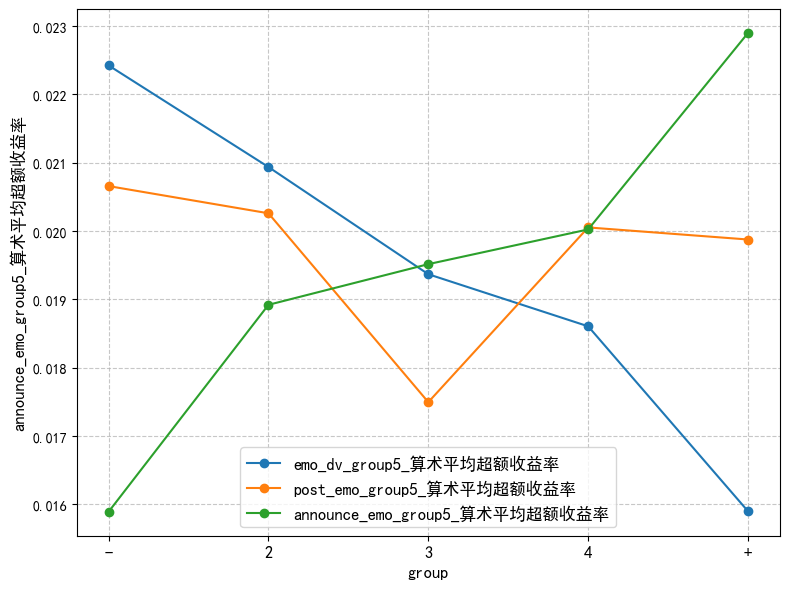

In [16]:
gp5_dv = calculate_results(divergence, 'emo_dv_group5')
gp5_post = calculate_results(divergence, 'post_emo_group5')
gp5_announce = calculate_results(divergence, 'announce_emo_group5')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

,emo_dv_group10_算术平均超额收益率,emo_dv_group10_方差,emo_dv_group10_夏普比,emo_dv_group10_收益率_t值,emo_dv_group10_收益率_p值
emo_dv_group10,,,,,
-,0.022165,0.007823,0.250595,3.129927,0.00209
2,0.022675,0.008281,0.249169,3.112125,0.002212
3,0.021716,0.007900,0.244326,3.051633,0.002679
4,0.020190,0.007712,0.229896,2.871406,0.004659
5,0.017928,0.007735,0.203850,2.546091,0.011869
6,0.020786,0.007803,0.235310,2.939022,0.003796
7,0.016741,0.007376,0.194926,2.434619,0.016043
8,0.020397,0.007235,0.239797,2.995068,0.003195
9,0.014302,0.006759,0.173969,2.172871,0.031309


,post_emo_group10_算术平均超额收益率,post_emo_group10_方差,post_emo_group10_夏普比,post_emo_group10_收益率_t值,post_emo_group10_收益率_p值
post_emo_group10,,,,,
-,0.020822,0.007518,0.240143,2.999391,0.003153
2,0.021323,0.007187,0.251526,3.141563,0.002013
3,0.018523,0.007113,0.219623,2.743092,0.006804
4,0.020249,0.008042,0.225798,2.820211,0.005427
5,0.016485,0.007754,0.187199,2.338119,0.020659
6,0.017327,0.007931,0.194553,2.429968,0.016242
7,0.021760,0.008048,0.242554,3.029494,0.002871
8,0.018426,0.008287,0.202412,2.52812,0.012468
9,0.018668,0.007419,0.216730,2.706952,0.007552


,announce_emo_group10_算术平均超额收益率,announce_emo_group10_方差,announce_emo_group10_夏普比,announce_emo_group10_收益率_t值,announce_emo_group10_收益率_p值
announce_emo_group10,,,,,
-,0.015268,0.006455,0.190043,2.373638,0.018839
2,0.016528,0.006792,0.200550,2.504873,0.013283
3,0.017752,0.006801,0.215265,2.688663,0.007959
4,0.020065,0.007648,0.229440,2.865711,0.004739
5,0.018673,0.007417,0.216821,2.70809,0.007528
6,0.020401,0.007663,0.233044,2.910724,0.004138
7,0.022447,0.008193,0.247990,3.097398,0.002318
8,0.017678,0.008267,0.194425,2.428365,0.016312
9,0.023133,0.008673,0.248403,3.102555,0.00228


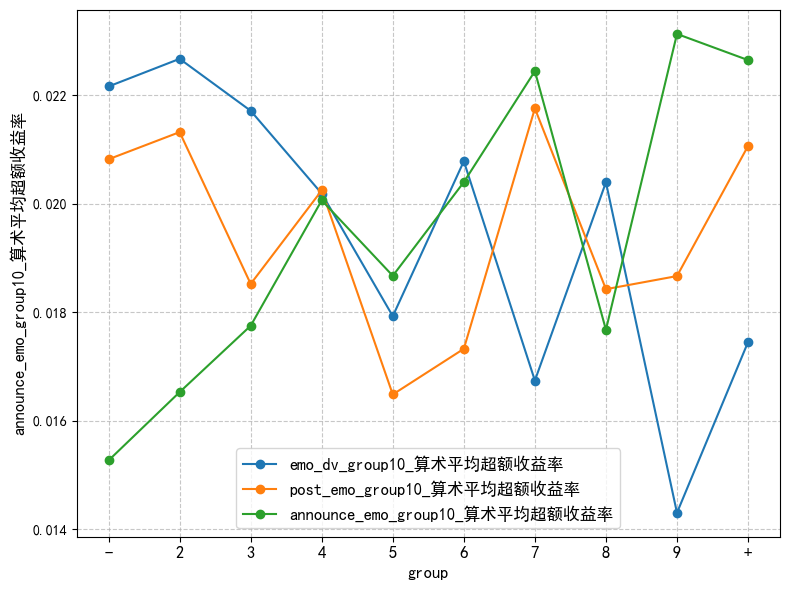

In [17]:
gp5_dv = calculate_results(divergence, 'emo_dv_group10', )
gp5_post = calculate_results(divergence, 'post_emo_group10')
gp5_announce = calculate_results(divergence, 'announce_emo_group10')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

,emo_dv_group5_加权平均超额收益率,emo_dv_group5_方差,emo_dv_group5_夏普比,emo_dv_group5_收益率_t值,emo_dv_group5_收益率_p值
emo_dv_group5,,,,,
-,0.022254,0.007275,0.260919,3.25888,0.001375
2,0.020681,0.007253,0.242837,3.033039,0.002839
3,0.018179,0.007351,0.212018,2.648099,0.008932
4,0.019270,0.007552,0.221743,2.769574,0.006299
+,0.016016,0.006683,0.195922,2.447069,0.01552
hedge,0.006238,0.000675,0.240066,2.998429,0.003162


,post_emo_group5_加权平均超额收益率,post_emo_group5_方差,post_emo_group5_夏普比,post_emo_group5_收益率_t值,post_emo_group5_收益率_p值
post_emo_group5,,,,,
-,0.023212,0.009967,0.232511,2.904064,0.004222
2,0.015251,0.006034,0.196325,NaN,NaN
3,0.018311,0.007515,0.211225,NaN,NaN
4,0.019841,0.007615,0.227363,2.839763,0.005121
+,0.018983,0.006628,0.233163,2.912205,0.004119
hedge,0.004229,0.001514,0.108687,1.357504,0.176594


,announce_emo_group5_加权平均超额收益率,announce_emo_group5_方差,announce_emo_group5_夏普比,announce_emo_group5_收益率_t值,announce_emo_group5_收益率_p值
announce_emo_group5,,,,,
-,0.015127,0.006286,0.190798,2.38307,0.01838
2,0.019234,0.006940,0.230879,2.883678,0.00449
3,0.018639,0.007079,0.221532,2.766935,0.006348
4,0.020089,0.007999,0.224615,2.805441,0.005669
+,0.022452,0.007913,0.252404,3.152521,0.001944
hedge,-0.007325,0.000972,-0.234953,-2.934562,0.003848


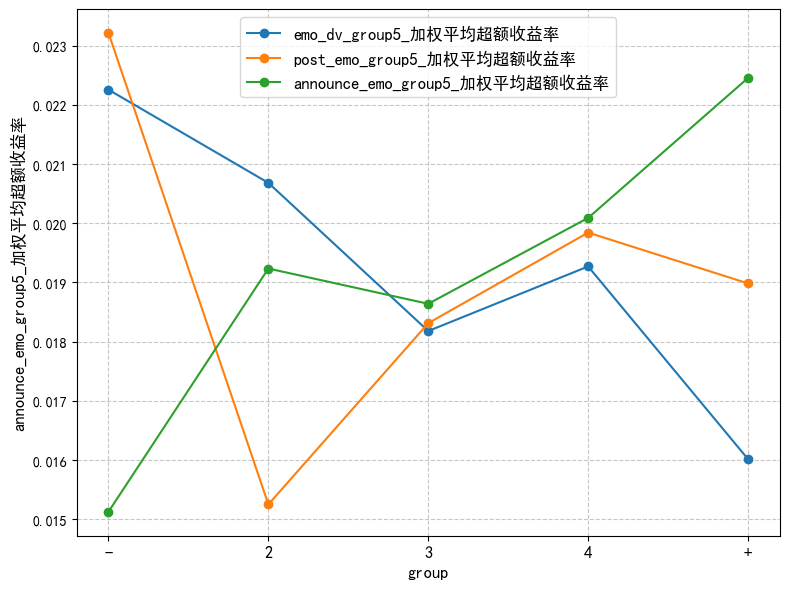

In [18]:
gp5_dv = calculate_results(divergence, 'emo_dv_group5','post_emo_weight5')
gp5_post = calculate_results(divergence, 'post_emo_group5', 'emo_dv_weight5')
gp5_announce = calculate_results(divergence, 'announce_emo_group5', 'announce_emo_weight5')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

,emo_dv_group10_加权平均超额收益率,emo_dv_group10_方差,emo_dv_group10_夏普比,emo_dv_group10_收益率_t值,emo_dv_group10_收益率_p值
emo_dv_group10,,,,,
-,0.021944,0.007656,0.250782,3.132272,0.002074
2,0.024132,0.008094,0.268242,3.350344,0.001014
3,0.021308,0.007455,0.246783,3.082317,0.002432
4,0.018560,0.007228,0.218307,2.726655,0.007135
5,0.016981,0.007605,0.194722,2.432075,0.016152
6,0.019463,0.007598,0.223287,2.788855,0.005953
7,0.017240,0.007813,0.195042,2.436071,0.015981
8,0.019898,0.007328,0.232450,2.9033,0.004232
9,0.015296,0.007037,0.182342,2.277454,0.024127


,post_emo_group10_加权平均超额收益率,post_emo_group10_方差,post_emo_group10_夏普比,post_emo_group10_收益率_t值,post_emo_group10_收益率_p值
post_emo_group10,,,,,
-,0.020114,0.009049,0.211443,2.640925,0.009115
2,0.021462,0.007652,0.245342,3.064315,0.002574
3,0.017149,0.006376,0.214769,2.682461,0.008101
4,0.019456,0.007663,0.222261,2.776043,0.006181
5,0.017098,0.008019,0.190940,2.384844,0.018295
6,0.017478,0.007777,0.198196,2.475462,0.014382
7,0.021630,0.008193,0.238969,2.984718,0.003299
8,0.017769,0.007547,0.204540,2.554709,0.011591
9,0.018134,0.007157,0.214363,2.67739,0.008219


,announce_emo_group10_加权平均超额收益率,announce_emo_group10_方差,announce_emo_group10_夏普比,announce_emo_group10_收益率_t值,announce_emo_group10_收益率_p值
announce_emo_group10,,,,,
-,0.013854,0.006331,0.174123,2.17479,0.031162
2,0.016338,0.006689,0.199755,2.49494,0.013646
3,0.017798,0.006800,0.215831,2.695723,0.0078
4,0.020704,0.007546,0.238331,2.976755,0.003381
5,0.017628,0.007208,0.207620,2.593179,0.01042
6,0.019609,0.007453,0.227136,2.83693,0.005164
7,0.022540,0.007976,0.252386,3.152305,0.001945
8,0.017673,0.008605,0.190520,2.379592,0.018548
9,0.021727,0.008363,0.237578,2.967351,0.003481


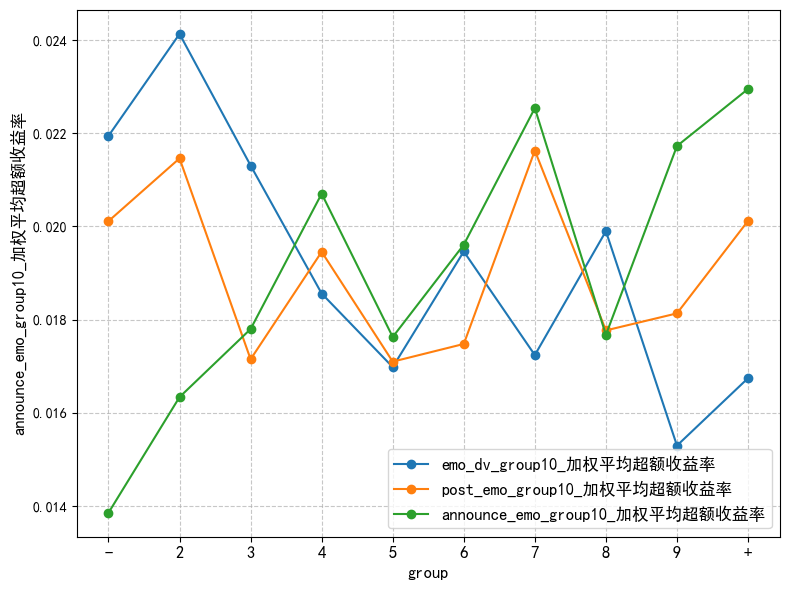

In [19]:
gp5_dv = calculate_results(divergence, 'emo_dv_group10', 'post_emo_weight10')
gp5_post = calculate_results(divergence, 'post_emo_group10', 'emo_dv_weight10')
gp5_announce = calculate_results(divergence, 'announce_emo_group10', 'announce_emo_weight10')
plot_specified_column([gp5_dv,gp5_post,gp5_announce], 1) 

In [20]:
# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的月度平均收益率
# for label, color in zip(labels, colors):
#     monthly_avg_returns = divergence[divergence['emo_dv_group5'] == label].groupby('month')['excess return'].mean()
#     ax.scatter(monthly_avg_returns.index, monthly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(monthly_hedge_returns.index, monthly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每个月的平均收益率')
# ax.set_xlabel('月份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




# #年度
# yearly_hedge_returns = divergence.groupby('year').apply(
#     lambda x: x.loc[x['emo_dv_group5'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group5'] == '+', 'excess return'].mean()
# )

# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的年度平均收益率
# for label, color in zip(labels, colors):
#     yearly_avg_returns = divergence[divergence['emo_dv_group5'] == label].groupby('year')['excess return'].mean()
#     ax.scatter(yearly_avg_returns.index, yearly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(yearly_hedge_returns.index, yearly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每年的平均收益率')
# ax.set_xlabel('年份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [21]:
# new_name = '情感分歧五分组'

# # 创建一个空的DataFrame以存储结果
# results_df = pd.DataFrame()


# # 计算每个月的加权平均超额收益率
# monthly_weighted_avg_returns = divergence.groupby(['month', 'emo_dv_group5']).apply(
#     lambda x: (x['excess return'] * x['emo_dv_weight5']).sum()
# ).unstack()
# avg_returns = monthly_weighted_avg_returns.mean()
# var_returns = monthly_weighted_avg_returns.var()
# # 将hedge收益率的平均值和方差加入到avg_returns和var_returns中
# hedge_returns = monthly_weighted_avg_returns.iloc[:, 0] - monthly_weighted_avg_returns.iloc[:, -1]
# avg_hedge_return = hedge_returns.mean()
# var_hedge_return = hedge_returns.var()
# avg_returns.loc['hedge'] = avg_hedge_return
# var_returns.loc['hedge'] = var_hedge_return

# results_df[f'{new_name}_加权平均超额收益率'] = avg_returns
# results_df[f'{new_name}_方差'] = var_returns
# results_df[f'{new_name}_夏普比'] = avg_returns / (var_returns ** 0.5)
# # 准备一个空的 DataFrame 来存储 t 检验的结果
# t_test_results = pd.DataFrame(index=monthly_weighted_avg_returns.columns, columns=['t值', 'p值'])

# # 对每个分组执行 t 检验
# for column in monthly_weighted_avg_returns.columns:
#     group = monthly_weighted_avg_returns[column]
#     t_stat, p_value = stats.ttest_1samp(group, 0)
#     t_test_results.loc[column, 't值'] = t_stat
#     t_test_results.loc[column, 'p值'] = p_value

# # 将结果添加到 results_df 中
# results_df[f'{new_name}_收益率_t值'] = t_test_results['t值']
# results_df[f'{new_name}_收益率_p值'] = t_test_results['p值']

# # 执行单样本 t 检验
# t_stat, p_value = stats.ttest_1samp(monthly_hedge_returns, 0)

# # 将 t 检验的结果加入到结果 DataFrame 中
# results_df[f'{new_name}_收益率_t值']['hedge'] = t_stat
# results_df[f'{new_name}_收益率_p值']['hedge'] = p_value
# # 显示数据表
# print("每个组合的统计数据表格：")
# display(results_df)

# # 绘图
# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(results_df.index, results_df[f'{new_name}_加权平均超额收益率'], marker='o', linestyle='-', color='b')
# ax.set_title(f'{new_name} - 加权平均超额收益率')
# ax.set_xlabel(new_name)
# ax.set_ylabel('加权平均超额收益率')
# ax.grid(True)

# plt.tight_layout()
# plt.show()

In [22]:
# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的月度平均收益率
# for label, color in zip(labels, colors):
#     monthly_avg_returns = divergence[divergence['emo_dv_group5'] == label].groupby('month')['excess return'].mean()
#     ax.scatter(monthly_avg_returns.index, monthly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(monthly_hedge_returns.index, monthly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每个月的平均收益率')
# ax.set_xlabel('月份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




# #年度
# yearly_hedge_returns = divergence.groupby('year').apply(
#     lambda x: x.loc[x['emo_dv_group5'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group5'] == '+', 'excess return'].mean()
# )

# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的年度平均收益率
# for label, color in zip(labels, colors):
#     yearly_avg_returns = divergence[divergence['emo_dv_group5'] == label].groupby('year')['excess return'].mean()
#     ax.scatter(yearly_avg_returns.index, yearly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(yearly_hedge_returns.index, yearly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每年的平均收益率')
# ax.set_xlabel('年份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [23]:
# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4','5','6','7','8','9', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的月度平均收益率
# for label, color in zip(labels, colors):
#     monthly_avg_returns = divergence[divergence['emo_dv_group10'] == label].groupby('month')['excess return'].mean()
#     ax.scatter(monthly_avg_returns.index, monthly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(monthly_hedge_returns.index, monthly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每个月的平均收益率')
# ax.set_xlabel('月份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




# #年度
# yearly_hedge_returns = divergence.groupby('year').apply(
#     lambda x: x.loc[x['emo_dv_group10'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group10'] == '+', 'excess return'].mean()
# )

# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4','5','6','7','8','9', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的年度平均收益率
# for label, color in zip(labels, colors):
#     yearly_avg_returns = divergence[divergence['emo_dv_group10'] == label].groupby('year')['excess return'].mean()
#     ax.scatter(yearly_avg_returns.index, yearly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(yearly_hedge_returns.index, yearly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每年的平均收益率')
# ax.set_xlabel('年份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [24]:
# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4','5','6','7','8','9', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的月度平均收益率
# for label, color in zip(labels, colors):
#     monthly_avg_returns = divergence[divergence['emo_dv_group10'] == label].groupby('month')['excess return'].mean()
#     ax.scatter(monthly_avg_returns.index, monthly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(monthly_hedge_returns.index, monthly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每个月的平均收益率')
# ax.set_xlabel('月份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




# #年度
# yearly_hedge_returns = divergence.groupby('year').apply(
#     lambda x: x.loc[x['emo_dv_group10'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group10'] == '+', 'excess return'].mean()
# )

# # 创建一个从浅蓝到深蓝的渐变色
# cmap = mcolors.LinearSegmentedColormap.from_list("LightDarkBlue", ["lightblue", "darkblue"])
# labels = ['-', '2', '3', '4','5','6','7','8','9', '+']
# colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# # 创建绘图
# fig, ax = plt.subplots(figsize=(12, 8))

# # 绘制每个组别的年度平均收益率
# for label, color in zip(labels, colors):
#     yearly_avg_returns = divergence[divergence['emo_dv_group10'] == label].groupby('year')['excess return'].mean()
#     ax.scatter(yearly_avg_returns.index, yearly_avg_returns.values, color=color, label=f'Group {label}')

# # 绘制hedge收益率
# ax.scatter(yearly_hedge_returns.index, yearly_hedge_returns.values, color='red', label='Hedge', marker='x')

# # 设置图表标题和标签
# ax.set_title('不同情感分歧组每年的平均收益率')
# ax.set_xlabel('年份')
# ax.set_ylabel('平均超额收益率')
# ax.legend(title='情感分歧组')
# ax.grid(True)

# # 适应横轴显示
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Step3：超额收益α检验
对五分组算术平均超额收益进行检验

In [25]:
FFFactor = pd.read_csv("E:\FF5.csv")
FFFactor['TradingMonth'] = pd.to_datetime(FFFactor['TradingMonth'], format='%Y-%m')
FFFactor = FFFactor[(FFFactor['MarkettypeID']=='P9714')& (FFFactor['Portfolios']==1)]
FFFactor = FFFactor.reset_index(drop = True)
FFFactor = FFFactor.rename(columns = {'TradingMonth':'month'})
display(FFFactor)

CHFactor = pd.read_excel(r"E:\CH.xlsx")
CHFactor['month'] = pd.to_datetime(CHFactor['month'], format='%Y-%m')
display(CHFactor)

,MarkettypeID,month,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1
0,P9714,2010-11-01,1,-0.049940,0.062281,-0.035990,0.016373,0.012258
1,P9714,2010-12-01,1,-0.007594,-0.005681,0.015797,0.005367,-0.017040
2,P9714,2011-01-01,1,-0.017814,-0.034425,0.040516,-0.009226,0.005638
3,P9714,2011-02-01,1,0.044323,0.054790,-0.030533,-0.040116,0.022328
4,P9714,2011-03-01,1,0.001873,0.017663,0.005710,-0.017481,0.006426
...,...,...,...,...,...,...,...,...
151,P9714,2023-06-01,1,0.011559,0.017546,-0.014614,0.015353,-0.008444
152,P9714,2023-07-01,1,0.034079,-0.026236,0.022162,-0.015374,0.026148
153,P9714,2023-08-01,1,-0.050368,0.014771,0.002148,0.003871,0.006052
154,P9714,2023-09-01,1,-0.005147,0.012936,0.017673,-0.005244,0.000004


,month,SMB,Rm-Rf,VMG,TO
0,2010-11-01,0.036993,-0.045532,0.005021,0.048626
1,2010-12-01,-0.013857,-0.010822,-0.017264,0.042922
2,2011-01-01,-0.020866,-0.022593,-0.036909,-0.014835
3,2011-02-01,0.039773,0.050719,0.044243,0.119426
4,2011-03-01,0.013540,-0.000179,0.000586,0.051559
...,...,...,...,...,...
151,2023-06-01,0.008584,0.014235,-0.014501,0.048765
152,2023-07-01,-0.011566,0.030921,-0.038585,-0.069907
153,2023-08-01,0.012822,-0.055323,-0.000622,-0.001914
154,2023-09-01,0.017078,-0.008278,-0.010721,0.028042


In [26]:
# Compute average excess returns for each group and each month
avg_returns_table = divergence.groupby(['emo_dv_group5', 'month'])['excess return'].mean().unstack()

# Compute monthly hedge returns
monthly_hedge_returns = divergence.groupby('month').apply(
    lambda x: x.loc[x['emo_dv_group5'] == '-', 'excess return'].mean() - x.loc[x['emo_dv_group5'] == '+', 'excess return'].mean()
)

# Convert hedge returns to DataFrame and transpose
monthly_hedge_returns_df = pd.DataFrame(monthly_hedge_returns, columns=['hedge']).T

# Combine average returns table with hedge returns
avg_returns_table_with_hedge = pd.concat([avg_returns_table, monthly_hedge_returns_df], axis=0)


def t_test_avg_returns(avg_returns_table_with_hedge):
    t_test_results = pd.DataFrame(columns=['group', 'alpha(×100)', 't-value', 'p-value'])

    for group in avg_returns_table_with_hedge.index:
        # 获取该组的平均回报数据
        data = avg_returns_table_with_hedge.loc[group].dropna()

        # 进行单样本t检验，检验均值是否为0
        t_stat, p_value = stats.ttest_1samp(data, 0)

        # 存储t值和p值
        results = pd.DataFrame({
            'group': [group],
            'alpha(×100)': [data.mean()*100],
            't-value': [t_stat],
            'p-value': [p_value]
        })
        t_test_results = pd.concat([t_test_results, results], ignore_index=True)

    return t_test_results

t_test_results = t_test_avg_returns(avg_returns_table_with_hedge)
print("raw return:")
display(t_test_results)

raw return:


,group,alpha(×100),t-value,p-value
0,-,2.242466,3.155511,0.001925
1,2,2.093816,2.995453,0.003191
2,3,1.936936,2.789342,0.005944
3,4,1.860722,2.749993,0.006669
4,+,1.590086,2.467246,0.014704
5,hedge,0.652380,3.689984,0.000310


In [27]:
def compute_OLS_results(factor_vars, divergence, model_name):
    # Prepare the factor variables DataFrame
    X = factor_vars
    X = sm.add_constant(X)

    # Initialize DataFrame to store OLS results
    ols_results_df = pd.DataFrame()

    # Perform regression for each group
    for group in avg_returns_table_with_hedge.index:
        y = avg_returns_table_with_hedge.loc[group].dropna()
        y_vec = y.values.flatten()

        # Generate design matrix for OLS
        X_mat = sm.add_constant(X[:len(y_vec)])  # Ensure X matches the length of y

        # Perform OLS regression if lengths match
        if len(y_vec) == X_mat.shape[0]:
            model = sm.OLS(y_vec, X_mat).fit()

            results = pd.DataFrame({
                'group': [group],
                'alpha(×100)': [model.params['const']*100],
                'std_err': [model.bse['const']],
                'R-squared': [model.rsquared],
                't-values': [model.tvalues['const']],
                'P-values': [model.pvalues['const']],
                'No. observations': [len(y_vec)]
            })
            ols_results_df = pd.concat([ols_results_df, results], ignore_index=True)
        else:
            print(f"Data mismatch for group {group}: skipping regression.")

    # Display OLS results
    print(model_name)
    display(ols_results_df)

    # Calculate and print the average absolute value of alpha
    Ar = np.mean(np.abs(ols_results_df['alpha(×100)']))
    print("Average |α| =", Ar)

    return ols_results_df, Ar




In [28]:
ols_results_df, Ar = compute_OLS_results(FFFactor[['RiskPremium1']], divergence, "CAPM模型:")
ols_results_df, Ar = compute_OLS_results(FFFactor[['RiskPremium1','SMB1','HML1','RMW1','CMA1']], divergence, "FF模型:")
ols_results_df, Ar = compute_OLS_results(CHFactor[['Rm-Rf','SMB','VMG']], divergence, "CH3模型:")
ols_results_df, Ar = compute_OLS_results(CHFactor[['Rm-Rf','SMB','VMG', 'TO']], divergence, "CH4模型:")

CAPM模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,2.177261,0.007061,0.021510,3.083352,0.002426,156
1,2,2.015147,0.006907,0.032363,2.917571,0.004056,156
2,3,1.858357,0.006860,0.032718,2.708856,0.007516,156
3,4,1.803049,0.006733,0.018563,2.677770,0.008215,156
4,+,1.541075,0.006426,0.014776,2.398254,0.017670,156
5,hedge,0.636186,0.001757,0.021436,3.621266,0.000397,156


Average |α| = 1.6718456902551246
FF模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,2.732443,0.007376,0.065097,3.704441,0.000297,156
1,2,2.601919,0.007215,0.075335,3.606088,0.000423,156
2,3,2.363774,0.007205,0.065828,3.280877,0.001287,156
3,4,2.274047,0.007085,0.048426,3.209513,0.001626,156
4,+,2.017017,0.006739,0.051234,2.993181,0.003230,156
5,hedge,0.715425,0.001835,0.065583,3.899681,0.000145,156


Average |α| = 2.1174374432789502
CH3模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,2.484594,0.007153,0.050724,3.473567,0.000669,156
1,2,2.339495,0.006996,0.061303,3.343920,0.001040,156
2,3,2.138615,0.006969,0.056347,3.068919,0.002545,156
3,4,2.088640,0.006839,0.042623,3.053830,0.002668,156
4,+,1.818375,0.006510,0.043832,2.793063,0.005893,156
5,hedge,0.666219,0.001801,0.027339,3.698564,0.000302,156


Average |α| = 1.92265621323875
CH4模型:


,group,alpha(×100),std_err,R-squared,t-values,P-values,No. observations
0,-,2.359921,0.010242,0.050907,2.304216,0.022574,156
1,2,2.127186,0.010016,0.061851,2.123879,0.035310,156
2,3,1.794154,0.009971,0.057810,1.799340,0.073962,156
3,4,1.788419,0.009788,0.043793,1.827173,0.069648,156
4,+,1.817687,0.009323,0.043832,1.949755,0.053058,156
5,hedge,0.542234,0.002576,0.030263,2.105329,0.036918,156


Average |α| = 1.7382669736325982


## Step4: Double Sorting

In [29]:
DbSt_df = divergence[['Stkcd','month', 'RCA','AG','ROA','BM','Size','MOM','excess return', 'emo_dv','emo_dv_group5']]
DbSt_df = DbSt_df[(DbSt_df['emo_dv_group5'] == '-') | (DbSt_df['emo_dv_group5'] == '+')]
DbSt_df = pd.merge(DbSt_df, FFFactor, on ='month')
DbSt_df = pd.merge(DbSt_df, CHFactor, on ='month')
display(DbSt_df)

,Stkcd,month,RCA,AG,ROA,BM,Size,MOM,excess return,emo_dv,emo_dv_group5,MarkettypeID,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1,SMB,Rm-Rf,VMG,TO
0,000004,2011-11-01,0.124402,-0.200825,0.097419,0.071840,1.029173e+09,-0.191291,-0.253797,2.502815,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106
1,000517,2011-11-01,0.000568,0.431880,0.040436,1.930832,1.321034e+09,-0.133122,-0.114175,1.980420,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106
2,000582,2011-11-01,0.101594,0.191714,0.052753,0.311125,9.575415e+08,-0.268235,-0.205189,2.714836,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106
3,000736,2011-11-01,0.003419,0.080086,0.062690,1.223913,1.195792e+09,-0.185321,-0.077674,-2.562404,-,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106
4,002046,2011-11-01,0.074004,0.208570,0.061357,0.360764,1.415700e+09,-0.359147,-0.231727,2.092359,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29713,603889,2017-12-01,0.152927,0.161661,0.106601,0.553898,2.148989e+09,-0.045695,0.025880,-2.389187,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
29714,603918,2017-12-01,0.019052,0.036889,0.036496,0.132875,3.329055e+09,-0.281728,0.303077,-5.143239,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
29715,603936,2017-12-01,0.100336,0.077021,0.028799,0.525846,1.478235e+09,-0.306329,-0.107676,0.587038,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272
29716,603979,2017-12-01,0.031252,0.076345,0.036087,1.165975,3.188267e+09,-0.333146,0.025126,0.692096,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272


In [30]:
def categorize_and_combine_labels(DbSt_df, column_name):
    # Step 1: Calculate the 30th and 70th percentiles
    low_threshold = DbSt_df[column_name].quantile(0.3)
    high_threshold = DbSt_df[column_name].quantile(0.7)
    
    # Step 2: Create High and Low categories, discard middle group
    conditions = [
        (DbSt_df[column_name] <= low_threshold),
        (DbSt_df[column_name] > high_threshold)
    ]
    choices = ['Low', 'High']
    DbSt_df['Category'] = pd.Series(pd.cut(DbSt_df[column_name], 
                                           bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
                                           labels=['Low', 'Mid', 'High']).astype(str))
    DbSt_df.loc[DbSt_df['Category'] == 'Mid', 'Category'] = np.nan

    # Step 3: Combine the new label with 'emo_dv_group5'
    combined_label_column = f"{column_name}-emo_dv_group"
    DbSt_df[combined_label_column] = DbSt_df['Category'] + '-' + DbSt_df['emo_dv_group5'].astype(str)

    # Drop the temporary 'Category' column
    DbSt_df.drop(columns=['Category'], inplace=True)
    
    return DbSt_df


DbSt_df = categorize_and_combine_labels(DbSt_df, 'RCA')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'AG')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'ROA')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'BM')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'Size')
DbSt_df = categorize_and_combine_labels(DbSt_df, 'MOM')


display(DbSt_df)

,Stkcd,month,RCA,AG,ROA,BM,Size,MOM,excess return,emo_dv,emo_dv_group5,MarkettypeID,Portfolios,RiskPremium1,SMB1,HML1,RMW1,CMA1,SMB,Rm-Rf,VMG,TO,RCA-emo_dv_group,AG-emo_dv_group,ROA-emo_dv_group,BM-emo_dv_group,Size-emo_dv_group,MOM-emo_dv_group
0,000004,2011-11-01,0.124402,-0.200825,0.097419,0.071840,1.029173e+09,-0.191291,-0.253797,2.502815,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106,High-+,Low-+,High-+,Low-+,Low-+,NaN
1,000517,2011-11-01,0.000568,0.431880,0.040436,1.930832,1.321034e+09,-0.133122,-0.114175,1.980420,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106,Low-+,High-+,NaN,High-+,NaN,NaN
2,000582,2011-11-01,0.101594,0.191714,0.052753,0.311125,9.575415e+08,-0.268235,-0.205189,2.714836,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106,High-+,High-+,NaN,Low-+,Low-+,Low-+
3,000736,2011-11-01,0.003419,0.080086,0.062690,1.223913,1.195792e+09,-0.185321,-0.077674,-2.562404,-,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106,Low--,NaN,High--,High--,Low--,NaN
4,002046,2011-11-01,0.074004,0.208570,0.061357,0.360764,1.415700e+09,-0.359147,-0.231727,2.092359,+,P9714,1,-0.053179,0.017016,-0.018001,-0.002132,0.007363,0.001692,-0.053547,0.026677,0.007106,High-+,High-+,High-+,Low-+,NaN,Low-+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29713,603889,2017-12-01,0.152927,0.161661,0.106601,0.553898,2.148989e+09,-0.045695,0.025880,-2.389187,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,High--,High--,High--,NaN,High--,NaN
29714,603918,2017-12-01,0.019052,0.036889,0.036496,0.132875,3.329055e+09,-0.281728,0.303077,-5.143239,-,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,Low--,NaN,NaN,Low--,High--,Low--
29715,603936,2017-12-01,0.100336,0.077021,0.028799,0.525846,1.478235e+09,-0.306329,-0.107676,0.587038,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,High-+,NaN,NaN,NaN,NaN,Low-+
29716,603979,2017-12-01,0.031252,0.076345,0.036087,1.165975,3.188267e+09,-0.333146,0.025126,0.692096,+,P9714,1,0.003557,-0.024180,-0.004586,0.018863,-0.019675,-0.022959,-0.000355,-0.016212,0.032272,NaN,NaN,NaN,High-+,High-+,Low-+


In [31]:
def t_test_grouped(DbSt_df, group_name):
    # Group by the specified group_name and month
    grouped = DbSt_df.groupby([group_name, 'month'])

    # Calculate the mean excess return for each group
    mean_returns = grouped['excess return'].mean().reset_index()

    # Group by the specified group_name again to perform the t-test
    grouped_mean = mean_returns.groupby(group_name)

    # Prepare a list to collect t-test results
    results = []

    # Perform t-test for each group
    for name, group in grouped_mean:
        t_stat, p_value = ttest_1samp(group['excess return'], 0)
        results.append((name, group['excess return'].mean()*100, t_stat, p_value))
    
    # Calculate High-hedge and Low-hedge excess return
    high_hedge_results = []
    low_hedge_results = []

    for month in mean_returns['month'].unique():
        high_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High--')]
        high_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High-+')]
        low_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low--')]
        low_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low-+')]
        
        if not high_minus_minus.empty and not high_plus.empty:
            high_hedge_return = high_plus['excess return'].values[0] - high_minus_minus['excess return'].values[0]
            high_hedge_results.append(high_hedge_return)
        
        if not low_minus.empty and not low_plus.empty:
            low_hedge_return = low_plus['excess return'].values[0] - low_minus['excess return'].values[0]
            low_hedge_results.append(low_hedge_return)

    # Perform t-test on High-hedge and Low-hedge excess return
    if high_hedge_results:
        high_hedge_t_stat, high_hedge_p_value = ttest_1samp(high_hedge_results, 0)
        results.append(('High-hedge', pd.Series(high_hedge_results).mean()*100, high_hedge_t_stat, high_hedge_p_value))
    if low_hedge_results:
        low_hedge_t_stat, low_hedge_p_value = ttest_1samp(low_hedge_results, 0)
        results.append(('Low-hedge', pd.Series(low_hedge_results).mean()*100, low_hedge_t_stat, low_hedge_p_value))

    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=[group_name, 'alpha(×100)', 't_stat', 'p_value'])

    print(f"{group_name} double sorting with High-hedge and Low-hedge:")
    display(results_df)


def ols_t_test_grouped(DbSt_df, group_name, X_df, model_name):
    # Group by the specified group_name and month
    grouped = DbSt_df.groupby([group_name, 'month'])

    # Calculate the mean excess return for each group
    mean_returns = grouped['excess return'].mean().reset_index()

    # Prepare a list to collect OLS regression results
    results = []

    # Perform OLS regression for each group
    for name, group in mean_returns.groupby(group_name):
        y = group['excess return'].reset_index(drop=True)
        # Ensure the X_df has the same number of rows as unique months in the group
        X = X_df[X_df['month'].isin(group['month'])]

        # Ensure X is aligned with y by month
        X = X.set_index('month').reindex(group['month']).reset_index(drop=True)

        if len(X) == len(y):
            # Add a constant (intercept) to the model
            X = sm.add_constant(X)

            # Fit the OLS model
            model = sm.OLS(y, X).fit()

            # Get the constant (intercept) t-value and p-value
            const_param = model.params['const']
            t_stat = model.tvalues['const']
            p_value = model.pvalues['const']
            results.append((name, const_param*100, t_stat, p_value))
        else:
            print(f"Mismatch in length for group {name}: len(X)={len(X)}, len(y)={len(y)}")

    # Calculate High-hedge and Low-hedge excess return
    high_hedge_results = []
    low_hedge_results = []

    for month in mean_returns['month'].unique():
        high_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High--')]
        high_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'High-+')]
        low_minus_minus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low--')]
        low_plus = mean_returns[(mean_returns['month'] == month) & (mean_returns[group_name] == 'Low-+')]
        
        if not high_minus_minus.empty and not high_plus.empty:
            high_hedge_return = high_plus['excess return'].values[0] - high_minus_minus['excess return'].values[0]
            high_hedge_results.append((month, high_hedge_return))
        
        if not low_minus_minus.empty and not low_plus.empty:
            low_hedge_return = low_plus['excess return'].values[0] - low_minus_minus['excess return'].values[0]
            low_hedge_results.append((month, low_hedge_return))

    # Convert hedge results to DataFrame
    high_hedge_df = pd.DataFrame(high_hedge_results, columns=['month', 'high_hedge_excess_return'])
    low_hedge_df = pd.DataFrame(low_hedge_results, columns=['month', 'low_hedge_excess_return'])

    # Perform OLS regression on High-hedge and Low-hedge excess return
    if not high_hedge_df.empty:
        y_high_hedge = high_hedge_df['high_hedge_excess_return']
        X_high_hedge = X_df[X_df['month'].isin(high_hedge_df['month'])]

        # Ensure X_high_hedge is aligned with y_high_hedge by month
        X_high_hedge = X_high_hedge.set_index('month').reindex(high_hedge_df['month']).reset_index(drop=True)

        if len(X_high_hedge) == len(y_high_hedge):
            # Add a constant (intercept) to the model
            X_high_hedge = sm.add_constant(X_high_hedge)

            # Fit the OLS model
            high_hedge_model = sm.OLS(y_high_hedge, X_high_hedge).fit()

            # Get the constant (intercept) t-value and p-value
            const_param_high_hedge = high_hedge_model.params['const']
            t_stat_high_hedge = high_hedge_model.tvalues['const']
            p_value_high_hedge = high_hedge_model.pvalues['const']
            results.append(('High-hedge', const_param_high_hedge*100, t_stat_high_hedge, p_value_high_hedge))
        else:
            print(f"Mismatch in length for high hedge: len(X_high_hedge)={len(X_high_hedge)}, len(y_high_hedge)={len(y_high_hedge)}")

    if not low_hedge_df.empty:
        y_low_hedge = low_hedge_df['low_hedge_excess_return']
        X_low_hedge = X_df[X_df['month'].isin(low_hedge_df['month'])]

        # Ensure X_low_hedge is aligned with y_low_hedge by month
        X_low_hedge = X_low_hedge.set_index('month').reindex(low_hedge_df['month']).reset_index(drop=True)

        if len(X_low_hedge) == len(y_low_hedge):
            # Add a constant (intercept) to the model
            X_low_hedge = sm.add_constant(X_low_hedge)

            # Fit the OLS model
            low_hedge_model = sm.OLS(y_low_hedge, X_low_hedge).fit()

            # Get the constant (intercept) t-value and p-value
            const_param_low_hedge = low_hedge_model.params['const']
            t_stat_low_hedge = low_hedge_model.tvalues['const']
            p_value_low_hedge = low_hedge_model.pvalues['const']
            results.append(('Low-hedge', const_param_low_hedge*100, t_stat_low_hedge, p_value_low_hedge))
        else:
            print(f"Mismatch in length for low hedge: len(X_low_hedge)={len(X_low_hedge)}, len(y_low_hedge)={len(y_low_hedge)}")

    # Convert results to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=[group_name, 'const_param(×100)', 't_stat', 'p_value'])


    print(f"{group_name} OLS t-test results under {model_name}:")
    display(results_df)

    
def double_sorting_under_different_model(group_name):
    t_test_grouped(DbSt_df, group_name)
    ols_t_test_grouped(DbSt_df, group_name, FFFactor[['month','RiskPremium1']], 'CAPM模型:')
    ols_t_test_grouped(DbSt_df, group_name, FFFactor[['month','RiskPremium1','SMB1','HML1','RMW1','CMA1']], 'FF5模型:')
    ols_t_test_grouped(DbSt_df, group_name, CHFactor[['month','Rm-Rf','SMB','VMG']], 'CH3模型:')
    ols_t_test_grouped(DbSt_df, group_name, CHFactor[['month','Rm-Rf','SMB','VMG','TO']], 'CH4模型:')


In [32]:
double_sorting_under_different_model('RCA-emo_dv_group')
double_sorting_under_different_model('AG-emo_dv_group')
double_sorting_under_different_model('ROA-emo_dv_group')
double_sorting_under_different_model('BM-emo_dv_group')
double_sorting_under_different_model('Size-emo_dv_group')
double_sorting_under_different_model('MOM-emo_dv_group')

RCA-emo_dv_group double sorting with High-hedge and Low-hedge:


,RCA-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.524821,2.148574,0.033221
1,High--,2.221884,3.118482,0.002168
2,Low-+,1.316153,1.982610,0.049178
3,Low--,2.345352,3.246048,0.001434
4,High-hedge,-0.697063,-2.425997,0.016414
5,Low-hedge,-1.029199,-2.994415,0.003202


RCA-emo_dv_group OLS t-test results under CAPM模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.454826,2.066591,0.040447
1,High--,2.145235,3.042717,0.002757
2,Low-+,1.274549,1.920987,0.056581
3,Low--,2.316602,3.198347,0.001678
4,High-hedge,-0.690410,-2.393697,0.017883
5,Low-hedge,-1.042054,-3.023621,0.002927


RCA-emo_dv_group OLS t-test results under FF5模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,2.124830,2.916945,0.004078
1,High--,2.729786,3.712781,0.000288
2,Low-+,1.660171,2.366077,0.019256
3,Low--,2.763833,3.636658,0.000379
4,High-hedge,-0.604956,-2.010798,0.046139
5,Low-hedge,-1.103662,-3.062778,0.002600


RCA-emo_dv_group OLS t-test results under CH3模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.794146,2.528742,0.012467
1,High--,2.494710,3.504315,0.000602
2,Low-+,1.502145,2.219167,0.027957
3,Low--,2.590377,3.523911,0.000562
4,High-hedge,-0.700564,-2.373428,0.018874
5,Low-hedge,-1.088233,-3.125030,0.002130


RCA-emo_dv_group OLS t-test results under CH4模型::


,RCA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.706608,1.679829,0.095058
1,High--,2.750527,2.699235,0.007742
2,Low-+,1.361081,1.404384,0.162258
3,Low--,2.275097,2.162614,0.032145
4,High-hedge,-1.043919,-2.480452,0.014219
5,Low-hedge,-0.914016,-1.834404,0.068562


AG-emo_dv_group double sorting with High-hedge and Low-hedge:


,AG-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.454300,2.218814,0.027952
1,High--,1.847589,2.470360,0.014581
2,Low-+,1.777736,2.693852,0.007841
3,Low--,2.333866,3.208125,0.001624
4,High-hedge,-0.393288,-1.250363,0.213051
5,Low-hedge,-0.556130,-1.893448,0.060162


AG-emo_dv_group OLS t-test results under CAPM模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.399609,2.144955,0.033525
1,High--,1.778288,2.393429,0.017895
2,Low-+,1.728717,2.626397,0.009501
3,Low--,2.261747,3.134646,0.002061
4,High-hedge,-0.378679,-1.201829,0.231275
5,Low-hedge,-0.533030,-1.821105,0.070532


AG-emo_dv_group OLS t-test results under FF5模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.978666,2.910485,0.004159
1,High--,2.356375,3.038019,0.002810
2,Low-+,2.064636,2.968007,0.003490
3,Low--,2.748788,3.625976,0.000394
4,High-hedge,-0.377709,-1.135896,0.257812
5,Low-hedge,-0.684152,-2.222050,0.027777


AG-emo_dv_group OLS t-test results under CH3模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.746848,2.659977,0.008653
1,High--,2.091227,2.778799,0.006145
2,Low-+,1.911052,2.845391,0.005048
3,Low--,2.554644,3.487930,0.000637
4,High-hedge,-0.344379,-1.065442,0.288366
5,Low-hedge,-0.643593,-2.160426,0.032307


AG-emo_dv_group OLS t-test results under CH4模型::


,AG-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.822279,1.937846,0.054508
1,High--,2.143673,1.989229,0.048482
2,Low-+,1.712602,1.781188,0.076892
3,Low--,2.283347,2.178021,0.030956
4,High-hedge,-0.321394,-0.694388,0.488506
5,Low-hedge,-0.570745,-1.338186,0.182847


ROA-emo_dv_group double sorting with High-hedge and Low-hedge:


,ROA-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.256437,1.828009,0.069471
1,High--,1.922132,2.696791,0.007776
2,Low-+,1.941091,2.982851,0.003318
3,Low--,2.786748,3.654206,0.000353
4,High-hedge,-0.665695,-2.470546,0.014574
5,Low-hedge,-0.755765,-1.991255,0.048222


ROA-emo_dv_group OLS t-test results under CAPM模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.200294,1.753501,0.081506
1,High--,1.869493,2.629555,0.009417
2,Low-+,1.889027,2.913745,0.004103
3,Low--,2.727768,3.598544,0.000432
4,High-hedge,-0.669199,-2.472940,0.014487
5,Low-hedge,-0.746396,-1.960329,0.051774


ROA-emo_dv_group OLS t-test results under FF5模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.896990,2.679014,0.008208
1,High--,2.520112,3.414678,0.000822
2,Low-+,2.230648,3.262231,0.001369
3,Low--,3.150869,3.940610,0.000125
4,High-hedge,-0.623122,-2.173863,0.031284
5,Low-hedge,-0.820440,-2.050675,0.042051


ROA-emo_dv_group OLS t-test results under CH3模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.604582,2.338339,0.020673
1,High--,2.206908,3.070686,0.002531
2,Low-+,2.147504,3.269615,0.001332
3,Low--,2.993537,3.873624,0.000159
4,High-hedge,-0.602326,-2.173623,0.031281
5,Low-hedge,-0.749421,-1.926729,0.055892


ROA-emo_dv_group OLS t-test results under CH4模型::


,ROA-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.563722,1.591379,0.113616
1,High--,2.312709,2.247324,0.026069
2,Low-+,1.948569,2.072376,0.039931
3,Low--,2.634442,2.380375,0.018551
4,High-hedge,-0.748987,-1.889194,0.060783
5,Low-hedge,-0.531138,-0.953812,0.341713


BM-emo_dv_group double sorting with High-hedge and Low-hedge:


,BM-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.263038,1.811699,0.072033
1,High--,2.112048,2.887626,0.004460
2,Low-+,1.629129,2.573280,0.011012
3,Low--,2.224323,3.005567,0.003093
4,High-hedge,-0.756797,-1.694576,0.092303
5,Low-hedge,-0.595194,-1.807596,0.072608


BM-emo_dv_group OLS t-test results under CAPM模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.178155,1.702331,0.090779
1,High--,2.044711,2.802270,0.005754
2,Low-+,1.569631,2.496505,0.013595
3,Low--,2.156235,2.932374,0.003877
4,High-hedge,-0.780877,-1.742482,0.083559
5,Low-hedge,-0.586604,-1.775058,0.077864


BM-emo_dv_group OLS t-test results under FF5模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.688903,2.330097,0.021180
1,High--,2.639830,3.439596,0.000762
2,Low-+,1.998728,3.029382,0.002886
3,Low--,2.695568,3.522614,0.000567
4,High-hedge,-0.767715,-1.611989,0.109217
5,Low-hedge,-0.696840,-2.016391,0.045544


BM-emo_dv_group OLS t-test results under CH3模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.487866,2.122970,0.035432
1,High--,2.346549,3.155838,0.001944
2,Low-+,1.847952,2.910094,0.004156
3,Low--,2.451474,3.292487,0.001235
4,High-hedge,-0.738054,-1.600106,0.111798
5,Low-hedge,-0.603522,-1.776804,0.077601


BM-emo_dv_group OLS t-test results under CH4模型::


,BM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.397389,1.409345,0.160859
1,High--,2.039407,1.934161,0.055041
2,Low-+,1.745202,1.919384,0.056822
3,Low--,2.565563,2.406442,0.017317
4,High-hedge,-0.539063,-0.831877,0.406885
5,Low-hedge,-0.820361,-1.688795,0.093323


Size-emo_dv_group double sorting with High-hedge and Low-hedge:


,Size-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.083756,1.330660,0.185783
1,High--,1.843903,2.079157,0.039631
2,Low-+,2.021426,2.669848,0.008506
3,Low--,2.672369,3.271852,0.001332
4,High-hedge,-0.934816,-2.092988,0.038457
5,Low-hedge,-0.741247,-2.034964,0.043812


Size-emo_dv_group OLS t-test results under CAPM模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,0.970507,1.195661,0.234167
1,High--,1.682730,1.935271,0.055215
2,Low-+,1.927999,2.552799,0.011790
3,Low--,2.636404,3.264580,0.001366
4,High-hedge,-0.864665,-1.942112,0.054487
5,Low-hedge,-0.718981,-1.971438,0.050734


Size-emo_dv_group OLS t-test results under FF5模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.305766,1.512973,0.132983
1,High--,2.217284,2.409685,0.017473
2,Low-+,2.475748,3.201728,0.001712
3,Low--,3.286421,3.905098,0.000145
4,High-hedge,-1.072100,-2.265949,0.025326
5,Low-hedge,-0.698361,-1.819623,0.071117


Size-emo_dv_group OLS t-test results under CH3模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.326551,1.620949,0.107675
1,High--,2.036852,2.305764,0.022798
2,Low-+,2.160828,2.840918,0.005201
3,Low--,2.958731,3.618140,0.000410
4,High-hedge,-0.910015,-1.990116,0.048910
5,Low-hedge,-0.713559,-1.920211,0.056988


Size-emo_dv_group OLS t-test results under CH4模型::


,Size-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.493854,1.320142,0.189343
1,High--,1.438235,1.183371,0.238963
2,Low-+,2.481544,2.329524,0.021338
3,Low--,2.718642,2.359352,0.019659
4,High-hedge,-0.341810,-0.548331,0.584518
5,Low-hedge,-0.203393,-0.394759,0.693663


MOM-emo_dv_group double sorting with High-hedge and Low-hedge:


,MOM-emo_dv_group,alpha(×100),t_stat,p_value
0,High-+,1.525047,1.876284,0.062698
1,High--,1.936187,2.415542,0.016983
2,Low-+,1.647256,2.097845,0.037563
3,Low--,1.797773,2.250654,0.025842
4,High-hedge,-0.972881,-2.076292,0.039764
5,Low-hedge,-0.222136,-0.507271,0.612700


MOM-emo_dv_group OLS t-test results under CAPM模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.437776,1.769014,0.079085
1,High--,1.852113,2.308365,0.022433
2,Low-+,1.497161,1.935621,0.054770
3,Low--,1.698411,2.133592,0.034492
4,High-hedge,-0.980401,-2.079475,0.039480
5,Low-hedge,-0.267673,-0.611612,0.541714


MOM-emo_dv_group OLS t-test results under FF5模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,2.076348,2.411708,0.017223
1,High--,2.478964,2.930615,0.003965
2,Low-+,2.070504,2.561601,0.011419
3,Low--,2.320236,2.780728,0.006134
4,High-hedge,-1.129581,-2.290999,0.023573
5,Low-hedge,-0.311169,-0.675715,0.500283


MOM-emo_dv_group OLS t-test results under CH3模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,1.784362,2.159663,0.032539
1,High--,2.182126,2.688733,0.008050
2,Low-+,1.913002,2.448101,0.015515
3,Low--,2.049575,2.533288,0.012334
4,High-hedge,-1.028465,-2.116901,0.036145
5,Low-hedge,-0.202541,-0.453521,0.650834


MOM-emo_dv_group OLS t-test results under CH4模型::


,MOM-emo_dv_group,const_param(×100),t_stat,p_value
0,High-+,2.116066,1.770359,0.078908
1,High--,1.871481,1.588062,0.114561
2,Low-+,2.429834,2.189825,0.030092
3,Low--,1.994311,1.736497,0.084557
4,High-hedge,-0.859162,-1.211156,0.228016
5,Low-hedge,0.380450,0.603572,0.547052


## Step5：FM回归

divergence存储了‘month’列（按照这个分组），存储了‘excess return’列作为因变量，emo_dv, RCA, AG, ROA, BM, Size作为自变量逐个加入回归。这样的话，假如我们有n个组（也就是n个月的时间截面），那么我们就得到了n组回归系数。我们要对这些回归系数进行描述性统计和t检验。

In [33]:

# # 存储回归系数和t值的字典
# coefficients = {}
# t_values = {}

# # 按月进行回归分析
# for month in divergence['month'].unique():
#     df_month = divergence[divergence['month'] == month]
#     # 初始时只包含 emo_dv 列
#     X = df_month[['emo_dv']]
#     X = sm.add_constant(X)  # 添加常数项
#     X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
#     y = df_month['excess return'].fillna(0)
#     model = sm.OLS(y, X).fit()
    
#     # 记录初始emo_dv的系数和t值
#     if 'step_1_emo_dv' not in coefficients:
#         coefficients['step_1_emo_dv'] = []
#         t_values['step_1_emo_dv'] = []
#     coefficients['step_1_emo_dv'].append(model.params['emo_dv'])
#     t_values['step_1_emo_dv'].append(model.tvalues['emo_dv'])
    
#     variables = ['RCA', 'AG', 'ROA', 'BM', 'Size', 'MOM']
#     for i, var in enumerate(variables):
#         X = pd.concat([X, df_month[[var]]], axis=1)  # 每次迭代添加一个变量列
#         X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
#         y = df_month['excess return'].fillna(0)
#         model = sm.OLS(y, X).fit()
#         if i != len(variables) - 1:
#             step_key1 = f'step_{i+2}_{var}'
#             if step_key1 not in coefficients:
#                 coefficients[step_key1] = []
#                 t_values[step_key1] = []
            
#             step_key2 = f'step_{i+2}_emo_dv'
#             if step_key2 not in coefficients:
#                 coefficients[step_key2] = []
#                 t_values[step_key2] = []
            
#             coefficients[step_key2].append(model.params['emo_dv'])
#             coefficients[step_key1].append(model.params[var])
#             t_values[step_key2].append(model.tvalues['emo_dv'])
#             t_values[step_key1].append(model.tvalues[var])
            
#             # 最后一次迭代记录所有变量的系数
#         elif i == len(variables) - 1:
#             for final_var in ['emo_dv'] + variables:
#                 final_step_key = f'step_{i+2}_{final_var}'
#                 if final_step_key not in coefficients:
#                     coefficients[final_step_key] = []
#                     t_values[final_step_key] = []
#                 coefficients[final_step_key].append(model.params[final_var])
#                 t_values[final_step_key].append(model.tvalues[final_var])

# # 将回归系数转为DataFrame
# coef_df = pd.DataFrame(coefficients)
# tval_df = pd.DataFrame(t_values)

# # 描述性统计
# desc_stats = coef_df.describe()
# print("描述性统计:")
# display(desc_stats)

# # t检验
# t_test_results = {}

# for col in coef_df.columns:
#     t_stat, p_value = stats.ttest_1samp(coef_df[col], 0)
#     t_test_results[col] = {'t-stat': t_stat, 'p-value': p_value}

# # 输出t检验结果
# t_test_df = pd.DataFrame(t_test_results).T
# print("\nt检验结果:")
# display(t_test_df)

调节异方差回归

In [34]:
# # 存储回归系数和调整后的t值的字典
# coefficients = {}
# adjusted_se = {}
# adjusted_t_values = {}

# # 按月进行回归分析
# for month in divergence['month'].unique():
#     df_month = divergence[divergence['month'] == month]
#     # 初始时只包含 emo_dv 列
#     X = df_month[['emo_dv']]
#     X = sm.add_constant(X)  # 添加常数项
#     X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
#     y = df_month['excess return'].fillna(0)
#     model = sm.OLS(y, X).fit()
    
#     # 记录初始emo_dv的系数和调整后的标准误差和t值
#     if 'step_1_emo_dv' not in coefficients:
#         coefficients['step_1_emo_dv'] = []
#         adjusted_se['step_1_emo_dv'] = []
#         adjusted_t_values['step_1_emo_dv'] = []
    
#     coefficients['step_1_emo_dv'].append(model.params['emo_dv'])
    
#     # 获取White's heteroskedasticity-consistent standard errors
#     hc_se = model.get_robustcov_results(cov_type='HC0').bse
#     adjusted_se['step_1_emo_dv'].append(hc_se[1])  # 使用位置索引
#     adjusted_t_values['step_1_emo_dv'].append(model.params['emo_dv'] / hc_se[1])
    
#     variables = ['RCA', 'AG', 'ROA', 'BM', 'Size', 'MOM']
#     for i, var in enumerate(variables):
#         X = pd.concat([X, df_month[[var]]], axis=1)  # 每次迭代添加一个变量列
#         X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
#         y = df_month['excess return'].fillna(0)
#         model = sm.OLS(y, X).fit()
#         if i != len(variables) - 1:
#             step_key1 = f'step_{i+2}_{var}'
#             step_key2 = f'step_{i+2}_emo_dv'
#             if step_key1 not in coefficients:
#                 coefficients[step_key1] = []
#                 adjusted_se[step_key1] = []
#                 adjusted_t_values[step_key1] = []
            
#             if step_key2 not in coefficients:
#                 coefficients[step_key2] = []
#                 adjusted_se[step_key2] = []
#                 adjusted_t_values[step_key2] = []
            
#             coefficients[step_key2].append(model.params['emo_dv'])
#             coefficients[step_key1].append(model.params[var])
            
#             # 获取White's heteroskedasticity-consistent standard errors
#             hc_se = model.get_robustcov_results(cov_type='HC0').bse
#             adjusted_se[step_key2].append(hc_se[1])  # 使用位置索引
#             adjusted_se[step_key1].append(hc_se[-1])  # 使用位置索引
#             adjusted_t_values[step_key2].append(model.params['emo_dv'] / hc_se[1])
#             adjusted_t_values[step_key1].append(model.params[var] / hc_se[-1])
            
#         elif i == len(variables) - 1:
#             for final_var in ['emo_dv'] + variables:
#                 final_step_key = f'step_{i+2}_{final_var}'
#                 if final_step_key not in coefficients:
#                     coefficients[final_step_key] = []
#                     adjusted_se[final_step_key] = []
#                     adjusted_t_values[final_step_key] = []
#                 coefficients[final_step_key].append(model.params[final_var])
                
#                 # 获取White's heteroskedasticity-consistent standard errors
#                 hc_se = model.get_robustcov_results(cov_type='HC0').bse
#                 adjusted_se[final_step_key].append(hc_se[len(X.columns) - X.columns.get_loc(final_var) - 1])  # 确保正确的索引
#                 adjusted_t_values[final_step_key].append(model.params[final_var] / hc_se[len(X.columns) - X.columns.get_loc(final_var) - 1])

# # 将回归系数转为DataFrame
# coef_df = pd.DataFrame(coefficients)
# adj_se_df = pd.DataFrame(adjusted_se)
# adj_tval_df = pd.DataFrame(adjusted_t_values)

# # 描述性统计
# desc_stats = coef_df.describe()
# print("描述性统计:")
# display(desc_stats)

# # 调整后的t检验
# adjusted_t_test_results = {}

# for col in adj_tval_df.columns:
#     t_stat, p_value = stats.ttest_1samp(adj_tval_df[col], 0)
#     adjusted_t_test_results[col] = {'t-stat': t_stat, 'p-value': p_value}

# # 输出调整后的t检验结果
# adjusted_t_test_df = pd.DataFrame(adjusted_t_test_results).T
# print("\n异方差调整后的t检验结果:")
# display(adjusted_t_test_df)

In [35]:
# 存储回归系数和调整后的t值的字典
coefficients = {}
adjusted_t_values = {}

# 计算lags
T = 156
lags = int(4 * (T / 100) ** (2 / 9))+1
print("lags=",lags)
# 按月进行回归分析
for month in divergence['month'].unique():
    df_month = divergence[divergence['month'] == month]
    # 初始时只包含 emo_dv 列
    X = df_month[['emo_dv']]
    X = sm.add_constant(X)  # 添加常数项
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    y = df_month['excess return'].fillna(0)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    
    # 记录初始emo_dv的系数和调整后的t值
    if 'step_1_emo_dv' not in coefficients:
        coefficients['step_1_emo_dv'] = []
        adjusted_t_values['step_1_emo_dv'] = []
    
    coefficients['step_1_emo_dv'].append(model.params['emo_dv'])
    adjusted_t_values['step_1_emo_dv'].append(model.tvalues['emo_dv'])
    
    variables = ['RCA', 'AG', 'ROA', 'BM', 'Size', 'MOM']
    for i, var in enumerate(variables):
        X = pd.concat([X, df_month[[var]]], axis=1)  # 每次迭代添加一个变量列
        X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
        #display(X)
        #Separate the constant term
        X_const = X[['const']]
        X_vars = X.drop(columns=['const'])
        
        # Normalize the features except the constant term
        scaler = StandardScaler()
        X_vars_scaled = pd.DataFrame(scaler.fit_transform(X_vars), columns=X_vars.columns, index=X_vars.index)

        # Combine the constant term and the normalized features
        X = pd.concat([X_const, X_vars_scaled], axis=1)
        #display(X)
        y = df_month['excess return'].fillna(0)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        if i != len(variables) - 1:
            step_key1 = f'step_{i+2}_{var}'
            step_key2 = f'step_{i+2}_emo_dv'
            if step_key1 not in coefficients:
                coefficients[step_key1] = []
                adjusted_t_values[step_key1] = []
            
            if step_key2 not in coefficients:
                coefficients[step_key2] = []
                adjusted_t_values[step_key2] = []
            
            coefficients[step_key2].append(model.params['emo_dv'])
            coefficients[step_key1].append(model.params[var])
            #adjusted_t_values[step_key2].append(model.tvalues['emo_dv'])
            #adjusted_t_values[step_key1].append(model.tvalues[var])
            
        elif i == len(variables) - 1:
            for final_var in ['emo_dv'] + variables:
                final_step_key = f'step_{i+2}_{final_var}'
                if final_step_key not in coefficients:
                    coefficients[final_step_key] = []
                    #adjusted_t_values[final_step_key] = []
                coefficients[final_step_key].append(model.params[final_var])

# 将回归系数转为DataFrame
coef_df = pd.DataFrame(coefficients)

# 描述性统计
desc_stats = coef_df.describe()
display(coef_df)
print("描述性统计:")
display(desc_stats)

# t检验
adjusted_t_test_results = {}

for col in coef_df.columns:
    t_stat, p_value = stats.ttest_1samp(coef_df[col], 0)
    
    adjusted_t_test_results[col] = {'t-stat': t_stat, 'p-value': p_value, 'coef': coef_df[col].mean()*100}

# 输出调整后的t检验结果
adjusted_t_test_df = pd.DataFrame(adjusted_t_test_results).T
print("\nNewy-West调整后的t检验结果:")
display(adjusted_t_test_df)

lags= 5


,step_1_emo_dv,step_2_RCA,step_2_emo_dv,step_3_AG,step_3_emo_dv,step_4_ROA,step_4_emo_dv,step_5_BM,step_5_emo_dv,step_6_Size,step_6_emo_dv,step_7_emo_dv,step_7_RCA,step_7_AG,step_7_ROA,step_7_BM,step_7_Size,step_7_MOM
0,0.013836,0.027785,0.019120,-0.002950,0.019419,0.017279,0.020348,-0.002394,0.020426,-0.009515,0.020797,0.020832,0.026042,-0.007573,0.012339,-0.005079,-0.006699,-0.014404
1,0.004291,-0.010121,0.005695,-0.010195,0.005887,-0.035172,0.008207,-0.004360,0.007616,0.008309,0.006843,0.006023,-0.001476,-0.001747,-0.031473,-0.001198,0.007770,0.008129
2,-0.002150,-0.011452,-0.004081,-0.012556,-0.002876,-0.010835,-0.004174,-0.020294,-0.009046,0.035556,-0.009432,-0.010134,-0.007721,0.000527,-0.007081,-0.006743,0.036599,0.005772
3,-0.010870,0.006934,-0.007224,0.001315,-0.007210,-0.001087,-0.007356,-0.007879,-0.007372,0.007064,-0.007919,-0.007086,0.007953,0.004457,0.001915,-0.004892,0.008143,0.008959
4,-0.003736,-0.003477,-0.004742,0.006963,-0.003849,-0.007694,-0.004346,0.011107,-0.004287,-0.009651,-0.003782,-0.003326,-0.003816,0.005797,-0.008971,0.006504,-0.008201,0.005087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-0.006773,-0.010626,-0.011448,-0.002098,-0.011758,0.002956,-0.011932,0.010419,-0.012419,0.000533,-0.012370,-0.015029,-0.013436,-0.005303,0.005386,0.007690,-0.003476,0.017686
152,-0.005596,-0.001365,-0.005853,0.000598,-0.005874,-0.000063,-0.005879,0.012079,-0.003856,0.023269,0.001231,0.002220,-0.000495,-0.005449,0.001819,0.022185,0.024913,0.006970
153,-0.008277,0.003385,-0.010736,0.000889,-0.010729,-0.000041,-0.010732,-0.008649,-0.011521,-0.002086,-0.011302,-0.011312,0.003719,0.001136,0.002182,-0.009437,-0.002116,0.001641
154,-0.014004,-0.001198,-0.012663,-0.012936,-0.010625,-0.007471,-0.011512,0.000253,-0.011515,-0.010437,-0.009017,-0.009220,0.000020,-0.009328,-0.000726,-0.005334,-0.010872,0.007746


描述性统计:


,step_1_emo_dv,step_2_RCA,step_2_emo_dv,step_3_AG,step_3_emo_dv,step_4_ROA,step_4_emo_dv,step_5_BM,step_5_emo_dv,step_6_Size,step_6_emo_dv,step_7_emo_dv,step_7_RCA,step_7_AG,step_7_ROA,step_7_BM,step_7_Size,step_7_MOM
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,-0.001320,-0.000357,-0.001794,-0.001725,-0.001814,-0.001483,-0.001889,-0.000991,-0.001925,-0.001497,-0.001775,-0.001616,-0.000229,-0.001419,-0.001478,-0.001364,-0.001203,0.000326
std,0.006106,0.008221,0.007110,0.006071,0.007095,0.009988,0.007015,0.009052,0.007056,0.013208,0.006986,0.006971,0.007581,0.006356,0.009427,0.008476,0.013240,0.010684
min,-0.024970,-0.020164,-0.025645,-0.018972,-0.025814,-0.035172,-0.025955,-0.025772,-0.026043,-0.075473,-0.024278,-0.023971,-0.020278,-0.021178,-0.031473,-0.021664,-0.074104,-0.033101
25%,-0.004755,-0.005226,-0.005764,-0.004992,-0.005876,-0.008161,-0.005959,-0.006358,-0.006028,-0.009288,-0.005905,-0.005680,-0.004300,-0.004980,-0.007511,-0.006802,-0.008268,-0.005963
50%,-0.001502,-0.001025,-0.001774,-0.002097,-0.001859,-0.001669,-0.002080,-0.001523,-0.002060,0.000524,-0.001948,-0.001658,-0.000344,-0.001627,-0.001803,-0.001760,0.000816,0.000575
75%,0.001791,0.003615,0.002465,0.001013,0.002547,0.004927,0.002519,0.004356,0.002175,0.006968,0.002185,0.002298,0.003591,0.001898,0.004366,0.004005,0.007335,0.006472
max,0.030307,0.032153,0.023009,0.022007,0.022993,0.032453,0.020348,0.024061,0.020426,0.035556,0.021022,0.021217,0.026042,0.021185,0.031828,0.023017,0.036599,0.032022



Newy-West调整后的t检验结果:


,t-stat,p-value,coef
step_1_emo_dv,-2.700343,0.007697,-0.132004
step_2_RCA,-0.541872,0.588684,-0.035666
step_2_emo_dv,-3.152267,0.001945,-0.179443
step_3_AG,-3.548860,0.000512,-0.172499
step_3_emo_dv,-3.192848,0.001706,-0.181384
step_4_ROA,-1.854597,0.065554,-0.148305
step_4_emo_dv,-3.363878,0.000969,-0.188944
step_5_BM,-1.366929,0.173627,-0.099072
step_5_emo_dv,-3.408168,0.000834,-0.192525
step_6_Size,-1.415267,0.158996,-0.149661
